In [1]:
%load_ext autoreload 
%autoreload 2

# TODO

- Take a unit cell
- Compute the supercell according to kmesh
- Choose a pair of atoms in the supercell
- Map their distance to [any (?)] periodic replica fulfilling the MIC
- Use mic_T as the argument of the Fourier Transform of $H_{ij\psi\phi}(k)$ to compute $H_{ij\psi\phi}(T)$
- Use the same mic_T to access the rascaline features computed in real space without PBCs

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
torch.set_default_dtype(torch.float64)

In [3]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

# Check that the Fourier Transform is invertible

In [63]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

In [64]:
def fourier_transform(H_k, kpts, T):
    return 1/np.sqrt(np.shape(kpts)[0])*np.sum([np.exp(2j*np.pi * np.dot(ki, T)) * H_ki for ki, H_ki in zip(kpts, H_k)], axis = 0)
    
def inverse_fourier_transform(H_T, T_list, k):
    return 1/np.sqrt(np.shape(T_list)[0])*np.sum([np.exp(-2j*np.pi * np.dot(k, Ti)) * H_Ti for Ti, H_Ti in zip(T_list, H_T)], axis = 0)

In [65]:
from skimage.util import view_as_blocks

In [7]:
blocks=view_as_blocs(H_k[0].numpy(), (5,5))

NameError: name 'view_as_blocs' is not defined

In [8]:
blocks[0,0]

NameError: name 'blocks' is not defined

In [9]:
def wallace_fourier_transform(H_k, kpts, T, frame, nao):
    from skimage.util import view_as_blocks
    block_H_k = np.array([view_as_blocks(H_k_.numpy(), (nao, nao)) for H_k_ in H_k])
    natm = frame.get_global_number_of_atoms()
    H_T = np.zeros((natm, natm, nao, nao), dtype = np.complex128)
    for i in range(natm):
        r_i = frame.positions[i]
        for j in range(natm):
            r_j = frame.positions[j]
            H_T[i, j] = 1/np.sqrt(np.shape(kpts)[0])* np.sum([np.exp(2j*np.pi * np.dot(ki, T + r_i - r_j)) * H_ki for ki, H_ki in zip(kpts, block_H_k[:, i, j, :, :])], axis = 0)
    return np.transpose(H_T, axes = (0,2,1,3)).reshape(natm*nao, natm*nao)
    
    
def wallace_inverse_fourier_transform(H_T, T_list, k, frame, nao):
    from skimage.util import view_as_blocks
    block_H_T = np.array([view_as_blocks(H_T_.numpy(), (nao, nao)) for H_T_ in H_T])
    natm = frame.get_global_number_of_atoms()
    H_k = np.zeros((natm, natm, nao, nao), dtype = np.complex128)
    for i in range(natm):
        r_i = frame.positions[i]
        for j in range(natm):
            r_j = frame.positions[j]
            H_k[i, j] = 1/np.sqrt(np.shape(T_list)[0])* np.sum([np.exp(-2j*np.pi * np.dot(k, Ti + r_i - r_j)) * H_Ti for Ti, H_Ti in zip(T_list, block_H_T[:, i, j, :, :])], axis = 0)
    return np.transpose(H_k, axes = (0,2,1,3)).reshape(natm*nao, natm*nao)

In [66]:
from mlelec.utils.pbc_utils import scidx_from_unitcell
import warnings 
def get_T_from_pair(frame, supercell, i, j, dummy_T, kmesh):
                       
    assert np.all(np.sign(dummy_T) >= 0) or np.all(np.sign(dummy_T) <= 0), "The translation indices must either be all positive or all negative (or zero)"
    sign = np.sum(dummy_T)
    if sign != 0:
        sign = sign/np.abs(sign)
    dummy_T = np.abs(dummy_T)
    supercell = frame.repeat(kmesh)
    I = i
    J = scidx_from_unitcell(frame, j = j, T = dummy_T, kmesh = kmesh)
    d = supercell.get_distance(I, J, mic = True, vector = True) - frame.positions[j] + frame.positions[i]
    mic_T = np.int32(np.round(np.linalg.inv(frame.cell.array).T@d))
    # mic_T, _ = fix_translation_sign(frame, np.int32(sign*mic_T), j, I)
    return I, J, np.int32(sign*mic_T)

In [67]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}
           }

In [176]:
root = 'examples/data/periodic/graphene_supercell_variety'

# names = ['hex'] #, 'hex22']
# ORBS = 'sto-3g'
# frames = read(f'{root}/graphene_variety.xyz', '1:2')
# for frame in frames:
#     frame.pbc = True
#     frame.positions[[0,1]] = frame.positions[[1,0]]
# kmesh = [[8,8,1], [4,4,1]]
# kfock = {name: np.load(f"{root}/fock_{name}_{''.join(map(str, kmesh[i]))}.npy") for i, name in enumerate(names)}
# kover = {name: np.load(f"{root}/over_{name}_{''.join(map(str, kmesh[i]))}.npy") for i, name in enumerate(names)}

# dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = kfock[name].reshape(1, *kfock[name].shape), 
#                                       overlap_kpoint = kover[name].reshape(1, *kfock[name].shape), target=["real_translation"],
#                                       device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS) for i,name in enumerate(names)}


root = 'examples/data/periodic/c2/'
names = ['hex']
ORBS = 'sto-3g'
START = 3
STOP = 4

frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
fock_range = range(START,STOP)
for frame in frames:
    frame.pbc = True
    frame.positions[[0,1]] = frame.positions[[1,0]]

kmesh = [8,8,1]
for f in frames:
    f.pbc = [True, True, True]
kfock = {name: np.array([np.load(f"examples/data/periodic/c2/fock_{ifock}_{''.join(map(str, kmesh))}.npy") 
                         for ifock in fock_range]
                       ) for name in names 
        }
kover = {name: np.array([np.load(f"examples/data/periodic/c2/over_{ifock}_{''.join(map(str, kmesh))}.npy") 
                         for ifock in fock_range]
                       ) for name in names 
        }

dataset ={name: PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock[name], overlap_kpoint=kover[name], 
                                     target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS]) for name in names}


In [149]:
name = 'hex'
# assert np.linalg.norm(kfock[name] - np.transpose(kfock[name], (0,2,1)).conj()) # Hk is hermitian
# assert np.linalg.norm(kfock[name][0] - np.transpose(kfock[name][0], (0,2,1)).conj()) # Hk is hermitian
frame = dataset[name].structures[0].copy()
kmesh = dataset[name].kmesh[0]

In [150]:
supercell = frame.repeat(kmesh)
i = 1
j = 0
dummy_T = [3,7,0]
print(get_T_from_pair(frame, supercell, i, j, dummy_T, kmesh))

(1, 62, array([ 3, -1,  0], dtype=int32))


In [151]:
kpts = dataset[name].cells[0].get_scaled_kpts(dataset[name].cells[0].make_kpts(kmesh))
H_k = dataset[name].matrices_kpoint[0]

### Dictionary structure

In [152]:
H_T = {}
H_minus_T = {}
T_list = np.zeros((frame.get_global_number_of_atoms(), supercell.get_global_number_of_atoms(), 3), dtype = np.int32)
counter_T = {}
counter_mT = {}
metacounter_T = {}
metacounter_mT = {}
metacounter = 0
for dummy_T in dataset[name].desired_shifts:
    for i in range(frame.get_global_number_of_atoms()):
        for j in range(frame.get_global_number_of_atoms()):
            I, J, mic_T = get_T_from_pair(frame, supercell, i, j, dummy_T, kmesh)
            mic_T = tuple(mic_T)
            if mic_T in [(-2,0,0), (-2,1,0)]:
                print(I,J,mic_T, dummy_T)
            if mic_T not in H_T:
                # metacounter_T[mic_T] = np.zeros((2,2))
                # metacounter_mT[mic_T] = np.zeros((2,2))
                counter_T[mic_T] = np.zeros((2,2))
                counter_mT[mic_T] = np.zeros((2,2))
                H_T[mic_T] = np.zeros((10, 10), dtype = np.complex128)
                H_minus_T[mic_T] = np.zeros((10, 10), dtype = np.complex128)
            # metacounter += 1
            # metacounter_T[mic_T][i,j] = metacounter        
            # metacounter_mT[mic_T][j,i] = metacounter        
            counter_T[mic_T][i,j] += 1
            counter_mT[mic_T][j,i] += 1
            H_T[mic_T][5*i:5*(i+1), 5*j:5*(j+1)] = fourier_transform(H_k, kpts, mic_T)[5*i:5*(i+1), 5*j:5*(j+1)]
            # H_T[mic_T][5*i:5*(i+1), 5*j:5*(j+1)] = wallace_fourier_transform(H_k, kpts, mic_T, dataset[name].structures[0], 5)[5*i:5*(i+1), 5*j:5*(j+1)]
            # H_T[mic_T][5*i:5*(i+1), 5*j:5*(j+1)] = fourier_transform(H_k, kpts, mic_T)[5*j:5*(j+1), 5*i:5*(i+1)]
            T_list[I, J] = mic_T
            # H_minus_T[mic_T][5*i:5*(i+1), 5*j:5*(j+1)] = wallace_fourier_transform(H_k, kpts, -np.array(mic_T), dataset[name].structures[0], 5)[5*j:5*(j+1), 5*i:5*(i+1)]
            H_minus_T[mic_T][5*j:5*(j+1), 5*i:5*(i+1)] = fourier_transform(H_k, kpts, -np.array(mic_T))[5*i:5*(i+1), 5*j:5*(j+1)]


# for mic_T in H_T:
#     assert np.allclose(H_T[mic_T], H_T[mic_T].real), np.allclose(H_T[mic_T], H_T[mic_T].real)
#     H_T[mic_T] = torch.from_numpy(H_T[mic_T].real)
#     assert np.allclose(H_minus_T[mic_T], H_minus_T[mic_T].real), np.allclose(H_minus_T[mic_T], H_minus_T[mic_T].real)
#     H_minus_T[mic_T] = torch.from_numpy(H_minus_T[mic_T].real)

0 96 (-2, 0, 0) [6 0 0]
0 97 (-2, 0, 0) [6 0 0]
1 96 (-2, 0, 0) [6 0 0]
1 97 (-2, 0, 0) [6 0 0]
0 98 (-2, 1, 0) [6 1 0]
0 99 (-2, 1, 0) [6 1 0]
1 98 (-2, 1, 0) [6 1 0]
1 99 (-2, 1, 0) [6 1 0]


In [153]:
H_T_fix = {}
H_minus_T_fix = {}
where_Ts_allowed ={}
T_list_fix = np.zeros((frame.get_global_number_of_atoms(), supercell.get_global_number_of_atoms(), 3), dtype = np.int32)
T_keys = list(counter_T.keys())
nao = 5


T_is_allowed = True
for iT, T in enumerate(T_keys):
    if T_is_allowed:
        where_Ts_allowed[T]=True
        H_T_fix[T] = np.zeros((10, 10), dtype = np.complex128)
        H_minus_T_fix[T] = np.zeros((10, 10), dtype = np.complex128)
    else:
        where_Ts_allowed[T]=False
        print(iT,T, T_is_allowed)
        T_is_allowed = True
        continue
    for i in range(len(counter_T[T])):
        for j in range(len(counter_T[T][0])):
            if counter_T[T][i,j] != 0:
                H_T_fix[T][nao*i:nao*(i+1), nao*j:nao*(j+1)] = fourier_transform(H_k, kpts, T)[nao*i:nao*(i+1), nao*j:nao*(j+1)]
                H_minus_T_fix[T][nao*j:nao*(j+1), nao*i:nao*(i+1)] = fourier_transform(H_k, kpts, -np.array(T))[nao*j:nao*(j+1), nao*i:nao*(i+1)]
            else:
                print(T, i,j ,' paired with',T_keys[iT+1] )
                assert counter_T[T_keys[iT+1]][i,j] != 0, (T_keys[iT+1], i, j, counter_T[T_keys[iT+1]][i,j])
                H_T_fix[T][nao*i:nao*(i+1), nao*j:nao*(j+1)] = fourier_transform(H_k, kpts, T_keys[iT+1])[nao*i:nao*(i+1), nao*j:nao*(j+1)]
                # Just to check that we are not overwriting 
                #assert np.linalg.norm(H_minus_T_fix[T][nao*j:nao*(j+1), nao*i:nao*(i+1)])==0 
                H_minus_T_fix[T][nao*j:nao*(j+1), nao*i:nao*(i+1)] = fourier_transform(H_k, kpts, -np.array(T_keys[iT+1]))[nao*j:nao*(j+1), nao*i:nao*(i+1)]
                # H_minus_T_fix[T][nao*i:nao*(i+1), nao*j:nao*(j+1)] = fourier_transform(H_k, kpts, -np.array(T_keys[iT+1]))[nao*j:nao*(j+1), nao*i:nao*(i+1)].T
                T_is_allowed = False
   
    # if T ==(-2,1,0):
    #     H_T_fix[T] = H_T_fix[(2,0,0)]
    #     H_minus_T_fix[T] = H_minus_T_fix[(2,0,0,)]

for mic_T in H_T_fix:
    assert np.allclose(H_T_fix[mic_T], H_T_fix[mic_T].real), np.allclose(H_T_fix[mic_T], H_T_fix[mic_T].real)
    H_T_fix[mic_T] = torch.from_numpy(H_T_fix[mic_T].real)
    assert np.allclose(H_minus_T_fix[mic_T], H_minus_T_fix[mic_T].real), np.allclose(H_minus_T_fix[mic_T], H_minus_T_fix[mic_T].real)
    H_minus_T_fix[mic_T] = torch.from_numpy(H_minus_T_fix[mic_T].real)

(0, 4, 0) 1 0  paired with (0, -4, 0)
5 (0, -4, 0) False
(2, -3, 0) 0 1  paired with (2, 5, 0)
23 (2, 5, 0) False
(-5, -3, 0) 0 1  paired with (3, 5, 0)
32 (3, 5, 0) False
(4, 0, 0) 1 0  paired with (-4, 0, 0)
36 (-4, 0, 0) False
(4, 4, 0) 1 0  paired with (-4, -4, 0)
41 (-4, -4, 0) False
(5, 3, 0) 1 0  paired with (-3, -5, 0)
49 (-3, -5, 0) False
(-2, 3, 0) 1 0  paired with (-2, -5, 0)
58 (-2, -5, 0) False


In [154]:
# for mic_T in H_T_fix:
#     mmic_T = -np.array(mic_T)
#     T = tuple([list(mic_T)[i] %kmesh[i] for i in range(3)])
#     mT = tuple([list(mmic_T)[i] %kmesh[i] for i in range(3)] )
#     # print(mic_T, T, mT, mmic_T)
#     assert np.allclose(dataset[name].matrices_translation[T]- dataset[name].matrices_translation[mT].transpose(1,2),0), dataset[name].matrices_translation[T]- dataset[name].matrices_translation[mT].T
#     assert np.allclose(H_T_fix[mic_T]- H_minus_T_fix[mic_T].T,0), H_T_fix[mic_T]- H_minus_T_fix[mic_T].T
#     # assert np.allclose(H_T_fix[mic_T], H_minus_T_fix[mmic_T].T), (mic_T, H_T_fix[mic_T], H_minus_T_fix[mmic_T].T)

# for mic_T in H_T:
#     mmic_T = -np.array(mic_T)
#     T = tuple([list(mic_T)[i] %kmesh[i] for i in range(3)])
#     mT = tuple([list(mmic_T)[i] %kmesh[i] for i in range(3)] )
#     # print(mic_T, T, mT, mmic_T)
#     assert np.allclose(dataset[name].matrices_translation[T]- dataset[name].matrices_translation[mT].transpose(1,2),0), dataset[name].matrices_translation[T]- dataset[name].matrices_translation[mT].T
#     assert np.allclose(H_T[mic_T]- H_minus_T[mic_T].T,0), H_T[mic_T]- H_minus_T[mic_T].T
    # assert np.allclose(H_T_fix[mic_T], H_minus_T_fix[mmic_T].T), (mic_T, H_T_fix[mic_T], H_minus_T_fix[mmic_T].T)

In [155]:
# ASSERT H(T) = H(-T)\dagger
for T in H_T_fix:
    # print(H_T_fix[T].shape, H_minus_T_fix[T].shape)
    assert np.isclose(torch.norm(H_T_fix[T]-H_minus_T_fix[T].T).item(), 0), (T, torch.norm(H_T_fix[T]-H_minus_T_fix[T].T).item())

In [156]:
reconstructed_H_k = []
for k in kpts:
    # reconstructed_H_k.append(inverse_fourier_transform(np.array(list(H_T_fix.values())), np.array(list(H_T_fix.keys())), k))
    reconstructed_H_k.append(inverse_fourier_transform(np.array(list(H_minus_T_fix.values())), -np.array(list(H_minus_T_fix.keys())), k))
    
    # reconstructed_H_k.append(inverse_fourier_transform(np.array(list(H_Tvalues())), np.array(list(H_T.keys())), k))
reconstructed_H_k = torch.from_numpy(np.array(reconstructed_H_k))
assert reconstructed_H_k.shape == H_k.shape

In [157]:
print(torch.norm(reconstructed_H_k-H_k))

tensor(5.1398e-12)


In [158]:
# SET matrices translation of the dataset 

# REMEMBER TO fix orbital order 
for name in ['hex']: 
    for ifr in range(len(dataset[name].structures)):
        # MUST BE A BETTER WAY TO DO THIS!
        for T in H_T_fix:
        # for T in dataset[name].matrices_translation[ifr]: 
            # dataset[name].matrices_translation[ifr][T] = fix_orbital_order(dataset[name].matrices_translation[ifr][T], dataset[name].structures[ifr], dataset[name].basis)
            H_T_fix[T] = fix_orbital_order(H_T_fix[T], dataset[name].structures[ifr], dataset[name].basis) # DONT FORGET to symm the matrix to symm
            H_minus_T_fix[T] = fix_orbital_order(H_minus_T_fix[T], dataset[name].structures[ifr], dataset[name].basis) # DONT FORGET to symm the matrix to symm

dataset[name].set_matrices_translation([H_T_fix])

# Compute targets

In [159]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, negative_shift_matrices, device ="cpu"):
    blocks = matrix_to_blocks(dataset, negative_shift_matrices, device = 'cpu')
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)
    

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [160]:
target_blocks = {name: get_targets(dataset[name], [H_minus_T_fix])[0] for name in ['hex']}
target_coupled_blocks = {name: get_targets(dataset[name], [H_minus_T_fix])[1] for name in ['hex']}

# MUST PASS 
check_target(target_coupled_blocks[name])

TARGET PASSED


In [161]:
# nb = 21
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

# nb = 22
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

# nb = 25
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

# nb = 26
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

In [162]:
# for k, b in target_coupled_blocks[name].items():
#     print(k, torch.norm(b.values))

In [163]:
for T in H_T_fix:
    if tuple(np.int32(-np.array(T))) not in H_T_fix:
        print(T, 'no')
    # else:
        # print(T, 'yes')

(0, 4, 0) no
(4, 0, 0) no
(4, 4, 0) no


In [30]:
np.unique(np.array(target_coupled_blocks['hex'][12].samples.view(['cell_shift_a','cell_shift_b','cell_shift_c']).values.tolist()),axis=0).shape

(64, 3)

## Reconstruct H_T, H_T_minus from the blocks 

In [82]:
from mlelec.utils.twocenter_utils import _to_matrix, _to_uncoupled_basis
from mlelec.utils.pbc_utils import blocks_to_matrix
predblocks = target_coupled_blocks['hex']
predblocks_un = _to_uncoupled_basis(predblocks)
recon_blocks = {}
tblocks = []
tblock_keys = []
for translation in dataset['hex'].desired_shifts[0]:
    block_keys = []
    blocks = []
    for key, block in predblocks_un.items():
            # TODO: replace labels_where
            # try:
            if True:
                lbl =Labels(
                        ["cell_shift_a", "cell_shift_b", "cell_shift_c"],
                        values=np.asarray(
                            [translation[0], translation[1], translation[2]]
                        ).reshape(1, -1),
                    )
                xx = block.samples.view(["cell_shift_a", "cell_shift_b", "cell_shift_c"]).values
                idx = np.where(np.all(np.isclose(np.array(xx),np.array([translation[0], translation[1], translation[2]])), 
                                      axis = 1))[0]


            # except:
            #     print("{} not found in {}".format(translation, key))
            #     continue

            if len(idx):
                tblock_keys.append(list(key.values)+[translation[0], translation[1], translation[2]])
    
                tblocks.append( TensorBlock(
                        samples=Labels(
                            predblocks.sample_names[:-3],
                            values=np.asarray(block.samples.values[idx])[:, :-3],
                        ),
                        values=block.values[idx],
                        components=block.components,
                        properties=block.properties,
                    ))
                

tmap = TensorMap(Labels(predblocks_un.keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"],np.asarray(tblock_keys)), tblocks)
predfocks, predfocks_m = blocks_to_matrix(tmap, dataset['hex'])


In [32]:
# for T in predfocks[0]: 
#     for i in range(2):
#         for j in range(2):
#             m1 = predfocks[0][T].clone()[i*5:(i+1)*5, j*5:(j+1)*5]
#             m2 = dataset['hex'].matrices_translation[0][T].clone()[i*5:(i+1)*5, j*5:(j+1)*5]
#             mask = torch.abs(m2)<1e-11
#             m2[mask]=0
#             m1[mask]=1
#             for row in m2/m1:
#                 for v in row:
#                     print(f'{v:>15.5f}', end = ' ')
#                 print()

In [33]:
# tmap = tmap.keys_to_samples('cell_shift_a')
# tmap = tmap.keys_to_samples('cell_shift_b')
# tmap = tmap.keys_to_samples('cell_shift_c')
# for k, b in target_blocks['hex'].items():
    # print(torch.linalg.norm(tmap.block(k).values - b.values))

In [83]:
# Error on reconstructed fock matrices from blocks 
i=1
j=0
for T in predfocks[0]:
    # idx1=slice(i*5,(i+1)*5)
    # idx2=slice(j*5,(j+1)*5)
    sum1 = predfocks[0][T]#[idx1, idx2]# + predfocks_m[T][0][idx2, idx1]
    sum2 = dataset[name].matrices_translation[0][T]#[idx1, idx2] #+ H_minus_T_fix[T][idx2, idx1]
    try: 
        assert torch.norm(sum1 - sum2)<1e-10
    except AssertionError: 
        print(T, torch.norm(sum1 - sum2), torch.norm(sum1), torch.norm(sum2)) #, torch.norm(predfocks[T][0][idx1, idx2]), torch(predfocks_m[T][0][idx2, idx1]), H_minus_T_fix[T][idx2, idx1], )

# Features

In [164]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

def get_pair_features(frames, hypers_atoms, hypers_pair, order_nu, all_pairs, both_centers, max_shift,  desired_shifts, mic, kmesh, device, lcut,return_rho0ij,counter,):
    return pair_features(frames, hypers_atoms, hypers_pair, order_nu=order_nu, all_pairs=all_pairs, both_centers=both_centers, max_shift=max_shift,
            desired_shifts=desired_shifts, mic=mic, kmesh=kmesh, device=device, lcut=lcut,return_rho0ij=return_rho0ij, counter = counter)

def rascaline_gij(dataset):
    from mlelec.features.acdc_utils import fix_gij, acdc_standardize_keys
    hypers_pair = {'cutoff': 12,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    from rascaline import SphericalExpansionByPair 
    calculator = SphericalExpansionByPair(**hypers_pair)
    gij= calculator.compute(dataset.structures)
    gij = fix_gij(gij)
    gij = acdc_standardize_keys(gij)
    return gij

def compute_features(dataset, counter = None, return_rho0ij = False, both_centers=True):
# +
    hypers_pair = {'cutoff': 4,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }

    hypers_atom = {'cutoff': 4,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.3,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    device = "cpu"
    # -

    LCUT = 3 #2*np.max([np.max( np.asarray(orbitals[ORBS][k])[:,1]) for k in orbitals[ORBS]])
    print("LCUT", LCUT)

    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2

    print(return_rho0ij)

    rhoij = get_pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers = both_centers,
                                max_shift = dataset.kmesh[0] ,  desired_shifts = dataset.desired_shifts, mic = True,
                                kmesh = dataset.kmesh[0], device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = counter)

    print('rhoij computed')
    if return_rho0ij:
        # return rhoij
        NU = 1 
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut=LCUT, device = device,
                                    feature_names = rhoij.property_names)
    # save('rhonui', rhonui, use_numpy = True)
    # print("rhonui saved", flush = True)
    return rhonui, rhoij

def compute_hfeat(rhonui, rhoij):
    hfeat = twocenter_features_periodic_NH(single_center=rhonui, pair= rhoij)
    return hfeat

In [165]:
# CHECK GIJ 
return_gij = True
both_centers = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, counter = [counter_T], both_centers = both_centers)
hfeat = compute_hfeat(rhonui, rhoij)
check_gij(hfeat)


LCUT 3
True
hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:144: UserWarning: Using cutoff 11.0 for all pairs feature
  warnings.warn(
/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:166: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


rhoij computed
3
l 0
k [1 1 0 6 6]
values tensor(0.) tensor(0.) tensor(4.1906) tensor(2.0953) tensor(2.0953) stupid tensor([], dtype=torch.int64)
3
l 1
k [1 1 1 6 6]
values tensor(0.) tensor(6.6721) tensor(0.) tensor(3.3360) tensor(3.3360) stupid tensor([], dtype=torch.int64)
3
l 2
k [1 1 2 6 6]
values tensor(0.) tensor(0.) tensor(7.6720) tensor(3.8360) tensor(3.8360) stupid tensor([], dtype=torch.int64)
3
l 3
k [1 1 3 6 6]
values tensor(0.) tensor(8.0875) tensor(0.) tensor(4.0437) tensor(4.0437) stupid tensor([], dtype=torch.int64)
3
l 4
k [1 1 4 6 6]
values tensor(0.) tensor(0.) tensor(8.2318) tensor(4.1159) tensor(4.1159) stupid tensor([], dtype=torch.int64)
gij ASSED


In [166]:
return_gij = False
both_centers = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, counter = [counter_T], both_centers = both_centers)
hfeat = compute_hfeat(rhonui, rhoij)

LCUT 3
False
hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:374: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


rhoij computed
3
l 0
k [3 1 0 6 6]
values tensor(3.9001) tensor(3.9001) tensor(15.8576) tensor(8.1651) tensor(8.1651) stupid tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62, 191, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253])
3
l 1
k [3 1 1 6 6]
values tensor(9.1450) tensor(25.9096) tensor(9.1450) tensor(13.7381) tensor(13.7381) stupid tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  1

In [167]:
# Missing keys in targets vs feats
# flabel=Labels(hfeat.sample_names[:-1], hfeat[12].samples.values[:,:-1])
# first = target_coupled_blocks['hex'][12].samples
# intersection, mapping_1, mapping_2 = first.intersection_and_mapping(flabel)
# print(flabel.values[mapping_2==-1])

In [88]:
for k, b in hfeat.items():
    print(k, torch.norm(b.values))

LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=0) tensor(7.5830)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0) tensor(1.5364e-15)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0) tensor(11.4332)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0) tensor(10.8470)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0) tensor(5.5085e-32)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0) tensor(1.1918e-15)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0) tensor(1.5692e-15)
LabelsEntry(order_nu=3, inversion_

In [168]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [169]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [170]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat, target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                  cell_shifts=dataset['hex'].desired_shifts[:], device = device)

In [171]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias = True)
print(loss_ridge_bias)

tensor(9.1766e-07)


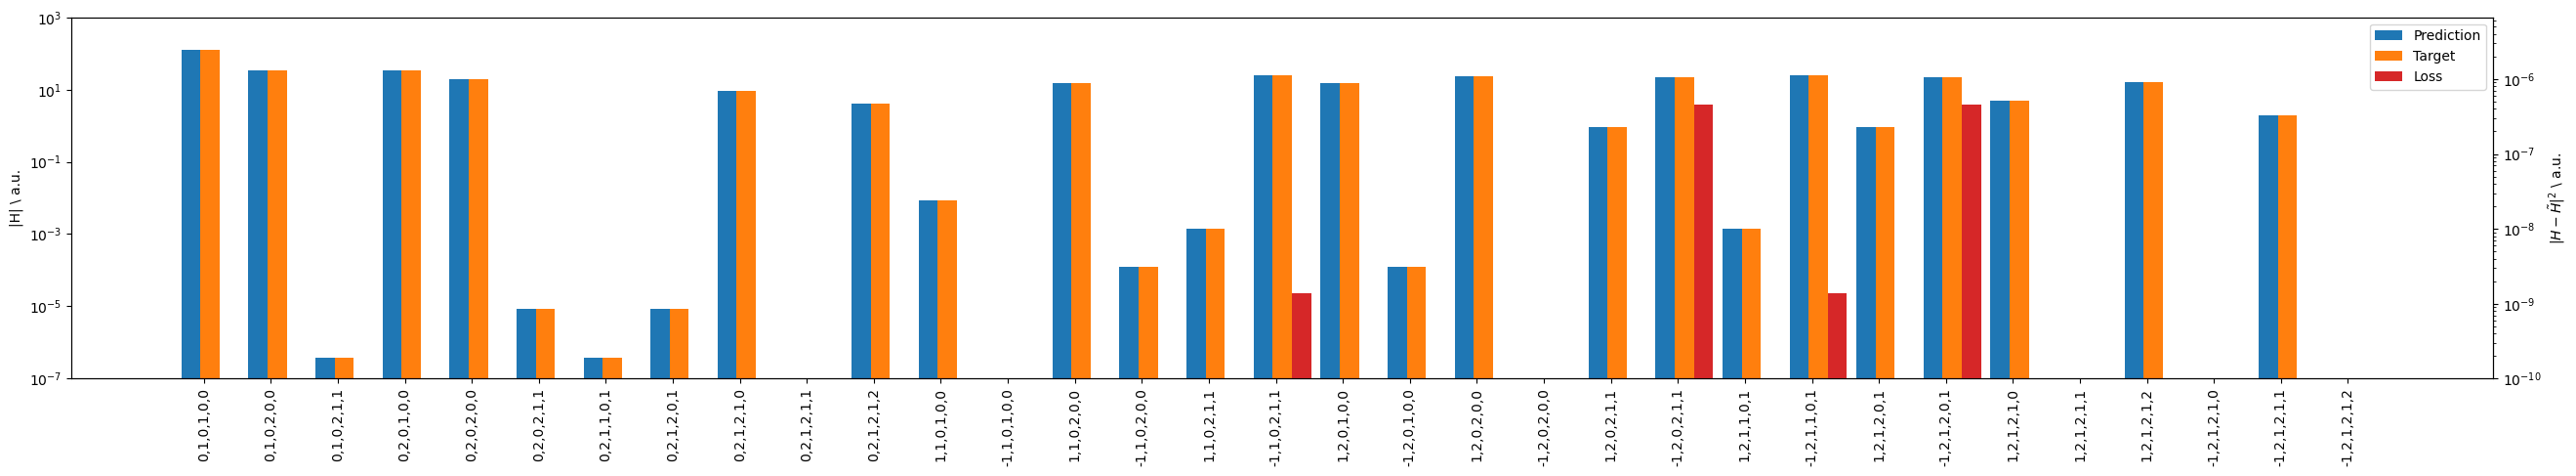

In [172]:
from mlelec.utils.plot_utils import plot_block_errors
plot_block_errors(pred_ridge_bias, target_coupled_blocks['hex'], plot_loss=True)

In [173]:
# view(frame)

In [174]:
sample_losses = {}
idx_losses = {}
for kt, bt in target_coupled_blocks['hex'].items():

    bp = pred_ridge_bias.block(kt) # find pred block for key
    block_loss = loss_blocks[tuple(kt.values)]
    # print(kt.values, block_loss)
    if block_loss> 1e-3: 
        sample_loss = torch.norm((bp.values - bt.values), dim=(1,2))
        sample_losses[tuple(kt)] = sample_loss
        idx_losses[tuple(kt)] = torch.where(sample_loss>1e-1)
        assert torch.isclose(sum(torch.pow(sample_loss,2) ), block_loss), (sum(sample_loss**2 ), block_loss)
        print(kt.values, torch.max(sample_loss), sample_loss.shape, block_loss, torch.sum(torch.pow(sample_loss,2)))#torch.where(sample_norm>1e-5))

Text(0.5, 0, 'sample idx')

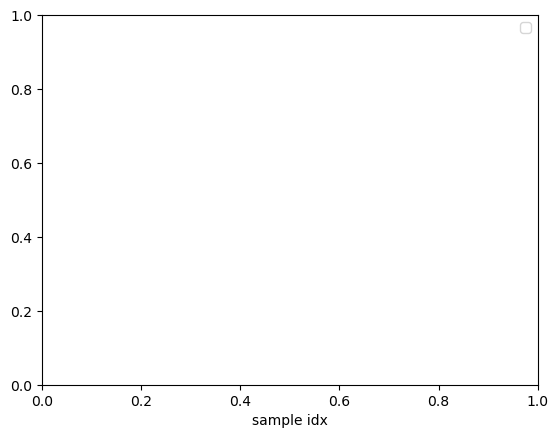

In [175]:
import matplotlib.pyplot as plt
for k, sample_loss in sample_losses.items():
    plt.plot(sample_loss, label = k)
plt.legend()
plt.xlabel('sample idx')
# plt.xlim([76,87])
# plt.plot(sample_loss)

In [451]:
idx_losses

{(1,
  6,
  1,
  0,
  6,
  2,
  0,
  0): (tensor([ 78,  79,  87,  93,  94,  95,  96, 102, 104, 151, 153, 158, 159, 160,
          161, 168, 175, 176]),),
 (-1,
  6,
  1,
  0,
  6,
  2,
  1,
  1): (tensor([ 78,  79,  87,  88,  93,  94,  95,  96, 102, 103, 104, 151, 152, 153,
          158, 159, 160, 161, 167, 168, 175, 176]),),
 (1,
  6,
  2,
  0,
  6,
  1,
  0,
  0): (tensor([ 78,  79,  87,  93,  94,  95,  96, 102, 104, 151, 153, 158, 159, 160,
          161, 168, 175, 176]),),
 (1,
  6,
  2,
  0,
  6,
  2,
  0,
  0): (tensor([ 71,  78,  79,  86,  87,  88,  93,  94,  95,  96, 101, 102, 103, 104,
          105, 150, 151, 152, 153, 154, 158, 159, 160, 161, 167, 168, 169, 175,
          176, 183]),),
 (-1,
  6,
  2,
  0,
  6,
  2,
  1,
  1): (tensor([ 71,  78,  79,  86,  87,  88,  93,  94,  95,  96,  97, 101, 102, 103,
          104, 105, 112, 142, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161,
          167, 168, 169, 175, 176, 183]),),
 (-1,
  6,
  2,
  1,
  6,
  1,
  0,
  1): (tenso

In [94]:
stupid_idx =[78,  79,  87,  88,  93,  94,  95,  96, 102, 103, 104, 151, 152, 153,
          158, 159, 160, 161, 167, 168, 175, 176]

FEAT_KEYIDX = 8
print(hfeat.keys[FEAT_KEYIDX])
print(hfeat[FEAT_KEYIDX].samples.values[stupid_idx]) 
# print(torch.norm(hfeat[FEAT_KEYIDX].values[stupid_idx][0]-hfeat[FEAT_KEYIDX].values[stupid_idx][0]))
print(torch.norm(hfeat[FEAT_KEYIDX].values[stupid_idx][0]-hfeat[FEAT_KEYIDX].values[stupid_idx][2]))


LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=1)
[[ 0  0  1 -2  0  0  1]
 [ 0  0  1 -2  1  0  1]
 [ 0  0  1 -1  0  0  1]
 [ 0  0  1 -1  1  0  1]
 [ 0  0  1  0 -2  0  1]
 [ 0  0  1  0 -1  0  1]
 [ 0  0  1  0  0  0  1]
 [ 0  0  1  0  1  0  1]
 [ 0  0  1  1 -2  0  1]
 [ 0  0  1  1 -1  0  1]
 [ 0  0  1  1  0  0  1]
 [ 0  1  0 -1  0  0  1]
 [ 0  1  0 -1  1  0  1]
 [ 0  1  0 -1  2  0  1]
 [ 0  1  0  0 -1  0  1]
 [ 0  1  0  0  0  0  1]
 [ 0  1  0  0  1  0  1]
 [ 0  1  0  0  2  0  1]
 [ 0  1  0  1 -1  0  1]
 [ 0  1  0  1  0  0  1]
 [ 0  1  0  2 -1  0  1]
 [ 0  1  0  2  0  0  1]]
tensor(1.2660)


In [95]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for _, i, j, Tx, Ty, _, _ in hfeat[9].samples.values[stupid_idx][:9]:
    ini = frame.positions[i]
    fin = frame.cell.array.T@np.array([Tx, Ty, 0]) + frame.positions[j]
    print(np.linalg.norm(fin-ini))
    ax.plot([ini[0], fin[0]], [ini[1], fin[1]], lw = 2, label = f'{np.linalg.norm(fin-ini):.3f}')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

atom_colors = {0: 'red', 1: 'lime'}
for Tx in range(-3,3):
    for Ty in range(-3, 3):
        for i in range(2):
            x, y = (frame.cell.array.T@np.array([Tx, Ty, 0]) + frame.positions[i])[:2]
            ax.plot([x], [y], 'o', markersize = 12, color = atom_colors[i])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

NameError: name 'plt' is not defined

In [96]:
gij = rascaline_gij(dataset['hex'])
gij_labels = []
gij_labels_pos = []
for lbl in hfeat[9].samples.values[stupid_idx]:
    gij_lbl = Labels(hfeat.sample_names[:-1], np.array([list(lbl)[:-1]]))[0]
    gij_labels.append(gij_lbl)
    gij_labels_pos.append(gij[0].samples.position(gij_lbl))
print(gij[0].values[gij_labels_pos])


tensor([[[-5.4447e-04,  1.6675e-03, -1.7210e-03, -1.0787e-02,  7.0352e-02,
           5.6510e-02,  8.5132e-03,  5.9326e-03, -1.1407e-03,  1.6537e-04]],

        [[-3.3304e-03,  4.8172e-03, -1.5310e-02,  6.3995e-02,  9.0114e-02,
           5.3728e-03,  1.2306e-02, -4.5153e-03,  1.3582e-03, -2.7205e-04]],

        [[ 7.1953e-03, -2.1235e-02,  9.3154e-02,  1.2102e-01, -9.8888e-04,
           1.7617e-02, -9.8015e-03,  4.5279e-03, -1.4720e-03,  2.4418e-04]],

        [[ 1.3910e-02,  5.8437e-02,  1.9813e-01,  1.9983e-02,  1.7815e-02,
          -8.0280e-03,  3.8034e-03, -1.5078e-03,  4.7412e-04, -8.7461e-05]],

        [[-5.4447e-04,  1.6675e-03, -1.7210e-03, -1.0787e-02,  7.0352e-02,
           5.6510e-02,  8.5132e-03,  5.9326e-03, -1.1407e-03,  1.6537e-04]],

        [[ 7.1953e-03, -2.1235e-02,  9.3154e-02,  1.2102e-01, -9.8888e-04,
           1.7617e-02, -9.8015e-03,  4.5279e-03, -1.4720e-03,  2.4418e-04]],

        [[ 3.0535e-01,  2.8557e-01,  4.7899e-03,  3.1029e-02, -1.9511e-02,
       

In [122]:
a=1.42
from ase import Atoms
import pyscf.pbc.gto as pbcgto
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

graphene = Atoms(symbols=['C','C'], cell=a/2*np.array([[3,-np.sqrt(3),0],[3,np.sqrt(3),0],[0,0,20]]), scaled_positions=[[1/3,1/3,0],[2/3,2/3,0]], pbc=[True,True,False])
cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(graphene)
cell.basis = 'sto-3g'
cell.a = graphene.cell
cell.verbose = 0
cell.precision=1e-8
cell.dimension=2
cell.build()

In [124]:
cell.atom_coord(0)

array([ 2.68341110e+00, -8.03387087e-18,  0.00000000e+00])

In [125]:
graphene.positions/0.529177

array([[ 2.68341217e+00, -8.03387407e-18,  0.00000000e+00],
       [ 5.36682433e+00, -1.60677481e-17,  0.00000000e+00]])

In [101]:
# T1 = -2,0,0
# T2 = -2,1,0
T1 = 0,0,0
T2 = 1,0,0
# T1 = -3,0,0
# T2 = -3,1,0
i = 0
j = 1 
Hij = {}
Hmij = {}
for T in [T1, T2]:
    H = H_T_fix[T]
    Hm = H_minus_T_fix[T]
    idx_i = slice(i*5,(i+1)*5)
    idx_j = slice(j*5,(j+1)*5)
    
    
    Hij[T] = H[idx_i, idx_j]
    Hmij[T] = Hm[idx_j, idx_i]
    
    # print(Hij)
    # print(Hmij)

In [102]:
fij = {}
fji = {} 
for T in [T1, T2]:
    fij_lbl = Labels(rhoij.sample_names, np.array([[0,i,j, *T,1]]))
    fji_lbl = Labels(rhoij.sample_names, np.array([[0,j,i, *T,-1]]))
    fij_idx = rhoij[0].samples.position(fij_lbl[0])
    fji_idx = rhoij[0].samples.position(fji_lbl[0])
    fij[T] = rhoij[0].values[fij_idx]
    fji[T] = rhoij[0].values[fji_idx]
#     print(fij)
#     print(fji)
# print('diff', torch.norm(fij - fji))
# print('sum', torch.norm(fij + fji))

In [103]:
# print(Hij[T1] - Hij[T2])
# print(Hmij[T1] - Hmij[T2])
# print(fij[T1] - fij[T2])
# print(fji[T1] - fji[T2])

def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>12.2e}', end = ' ')
        print()

for T in [T1, T2]:
    print(T)
    print('-')
    print_matrix(Hij[T] - Hmij[T])
    print('F', fij[T] - fji[T])
    print('\n+')
    print_matrix(Hij[T] + Hmij[T])
    print('F', fij[T] + fji[T])
# print(Hmij[T1] - Hmij[T2])
# print(fij[T1] - fij[T2])
# print(fji[T1] - fji[T2])


(0, 0, 0)
-
    2.17e-19     1.05e-12    -1.17e-10     4.87e-14     1.16e+01 
   -1.05e-12     0.00e+00     6.61e-10    -1.74e-14     9.91e+00 
    1.17e-10    -6.61e-10     0.00e+00     2.62e-15    -5.31e-11 
   -4.87e-14     1.74e-14    -2.62e-15     0.00e+00     5.40e-16 
   -1.16e+01    -9.91e+00     5.31e-11    -5.40e-16     0.00e+00 
F tensor([[0.0000e+00, 0.0000e+00, 8.6736e-19,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

+
   -2.53e-03    -7.00e+00     1.35e-11    -2.38e-15    -8.91e-12 
   -7.00e+00    -1.08e+01     6.23e-11    -5.96e-15     3.27e-11 
    1.35e-11     6.23e-11    -3.36e+00    -3.14e-14     6.79e-10 
   -2.38e-15    -5.96e-15    -3.14e-14    -3.64e+00    -3.18e-14 
   -8.91e-12     3.27e-11     6.79e-10    -3.18e-14     4.94e+00 
F tensor([[ 5.8095e-01,  5.4332e-01,  9.1133e-03,  ...,  9.3256e-07,
         -4.1161e-07,  1.1528e-07]])
(1, 0, 0)
-
   -5.64e-18    -3.60e-12     1.00e+01     3.54e-14    -5.78e+00 
    3.60e-12    -1.78e-15     8.58e+00   

In [104]:
for T in [T1, T2]:
    print(T)
    # print('-')
    print_matrix(Hij[T])
    print(fij[T])
    print()
    # print('\n+')
    # print_matrix(Hij[T] + Hmij[T])
    # print(fij[T] + fji[T])

(0, 0, 0)
   -1.26e-03    -3.50e+00    -5.17e-11     2.32e-14     5.78e+00 
   -3.50e+00    -5.39e+00     3.62e-10    -1.17e-14     4.96e+00 
    6.52e-11    -2.99e-10    -1.68e+00    -1.44e-14     3.13e-10 
   -2.55e-14     5.70e-15    -1.70e-14    -1.82e+00    -1.56e-14 
   -5.78e+00    -4.96e+00     3.66e-10    -1.61e-14     2.47e+00 
tensor([[ 2.9047e-01,  2.7166e-01,  4.5567e-03,  ...,  4.6628e-07,
         -2.0581e-07,  5.7641e-08]])

(1, 0, 0)
   -1.26e-03    -3.50e+00     5.00e+00     1.93e-14    -2.89e+00 
   -3.50e+00    -5.39e+00     4.29e+00    -8.30e-15    -2.48e+00 
   -5.00e+00    -4.29e+00     1.43e+00    -1.97e-14    -1.80e+00 
   -1.61e-14     8.88e-15    -2.25e-14    -1.82e+00    -4.54e-15 
    2.89e+00     2.48e+00    -1.80e+00    -1.45e-15    -6.43e-01 
tensor([[ 2.9047e-01,  2.7166e-01,  4.5567e-03,  ...,  4.6628e-07,
         -2.0581e-07,  5.7641e-08]])



In [58]:
TARGET_KEYIDX = 12
print(target_coupled_blocks['hex'].keys[TARGET_KEYIDX])
target_labels = []
target_labels_pos = []
for lbl in hfeat[FEAT_KEYIDX].samples.values[stupid_idx]:
    tar_lbl = Labels(hfeat.sample_names[:-1], np.array([list(lbl)[:-1]]))[0]
    target_labels.append(tar_lbl)
    target_labels_pos.append(target_coupled_blocks['hex'][TARGET_KEYIDX].samples.position(tar_lbl))


LabelsEntry(block_type=-1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=1, l_j=0, L=0)


In [189]:

target_coupled_blocks['hex'][TARGET_KEYIDX].values[target_labels_pos]


tensor([[[ 4.5136e-18]],

        [[-5.7019e-19]],

        [[ 3.2630e-18]],

        [[-1.7777e-18]],

        [[-1.8208e-19]],

        [[ 1.0503e-17]],

        [[ 0.0000e+00]],

        [[-1.0120e-17]],

        [[-1.0781e-18]],

        [[ 2.2904e-18]],

        [[-3.3732e-18]],

        [[ 3.3732e-18]],

        [[-2.2904e-18]],

        [[ 1.0781e-18]],

        [[ 1.0120e-17]],

        [[ 0.0000e+00]],

        [[-1.0503e-17]],

        [[ 1.8208e-19]],

        [[ 1.7777e-18]],

        [[-3.2630e-18]],

        [[ 5.7019e-19]],

        [[-4.5136e-18]]])

In [49]:
print(gij[1].values[gij_labels_pos])


tensor([[[ 7.9281e-03, -2.3512e-02,  1.0251e-01,  1.3396e-01, -1.0604e-03,
           1.9492e-02, -1.0829e-02,  4.9994e-03, -1.6249e-03,  2.6954e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-9.1546e-03,  2.7149e-02, -1.1837e-01, -1.5468e-01,  1.2245e-03,
          -2.2508e-02,  1.2505e-02, -5.7728e-03,  1.8763e-03, -3.1123e-04]],

        [[ 1.1892e-02, -3.5268e-02,  1.5377e-01,  2.0094e-01, -1.5906e-03,
           2.9238e-02, -1.6244e-02,  7.4991e-03, -2.4374e-03,  4.0430e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.2887e-03,  6.7872e-03, -2.9592e-02, -3.8670e-02,  3.0612e-04,
          -5.6269e-03,  3.1262e-03, -1.4432e-03,  4.6908e-04, -7.7808e-05]],

        [[ 3.3498e-01,  3.7729e-01,  1.0549e-02,  4.1507e-02, -2.7563e-02,
           1.94

In [46]:
gij[0]

TensorBlock
    samples (338): ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c']
    components (1): ['spherical_harmonics_m']
    properties (10): ['species_neighbor_1', 'n_1']
    gradients: None

# BEGIN

## predict with ridge models

In [50]:

def rascaline_gij(dataset):
    hypers_pair = {'cutoff': 12,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    from rascaline import SphericalExpansionByPair 
    calculator = SphericalExpansionByPair(**hypers_pair)
    return calculator.compute(dataset.structures)



In [68]:
# view(dataset['hex'].structures)
return_gij = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, counter = [counter_T], where_Ts_allowed=where_Ts_allowed)
hfeat = compute_hfeat(rhonui, rhoij)

LCUT 3
True
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:145: UserWarning: Using cutoff 12.0 for all pairs feature
  warnings.warn(
/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


rhoij computed
3
l 0
k [1 1 0 6 6]
values tensor(0.) tensor(0.) tensor(3.8849) tensor(1.9424) tensor(1.9424) stupid tensor([], dtype=torch.int64)
3
l 1
k [1 1 1 6 6]
values tensor(0.) tensor(6.2451) tensor(0.) tensor(3.1226) tensor(3.1226) stupid tensor([], dtype=torch.int64)
3
l 2
k [1 1 2 6 6]
values tensor(0.) tensor(0.) tensor(7.2394) tensor(3.6197) tensor(3.6197) stupid tensor([], dtype=torch.int64)
3
l 3
k [1 1 3 6 6]
values tensor(0.) tensor(7.6702) tensor(0.) tensor(3.8351) tensor(3.8351) stupid tensor([], dtype=torch.int64)
3
l 4
k [1 1 4 6 6]
values tensor(0.) tensor(0.) tensor(7.8410) tensor(3.9205) tensor(3.9205) stupid tensor([], dtype=torch.int64)


## to debug: 


In [69]:

I = 0 
J = 1
for k,b in rhoij.items():
    L = k['spherical_harmonics_l']
    
    for Tx, Ty, Tz in T_keys:
        sample_label_ij = Labels(
                        b.samples.names,
                        np.array([[0, I, J, Tx, Ty, Tz, 1,]]))
        
        sample_label_ji = Labels(
                        b.samples.names,
                        np.array([[0, J, I, Tx, Ty, Tz, -1]])
        )
        pos_ij = np.where(np.all(b.samples.values == sample_label_ij.values, axis=1))[0]
        
                    # pos_ij = b.samples.position(sample_label_ij[0])
        pos_ji = np.where(np.all(b.samples.values == sample_label_ji.values, axis=1))[0]
    
        try: 
            assert torch.norm(b.values[pos_ij] - (-1)**L * b.values[pos_ji])<=1e-6
        except AssertionError:
            print(k, pos_ij, pos_ji)

In [71]:
b.values[pos_ij]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.7180e-03,  3.3053e-02,  1.4220e-01,  1.8015e-02,  1.1632e-02,
          -4.5072e-03,  1.8525e-03, -6.3160e-04,  1.8964e-04, -3.7507e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.2996e-02, -4.9272e-02, -2.1198e-01, -2.6855e-02, -1.7340e-02,
           6.7189e-

In [72]:
b.values[pos_ji]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.7180e-03,  3.3053e-02,  1.4220e-01,  1.8015e-02,  1.1632e-02,
          -4.5072e-03,  1.8525e-03, -6.3160e-04,  1.8964e-04, -3.7507e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.2996e-02, -4.9272e-02, -2.1198e-01, -2.6855e-02, -1.7340e-02,
           6.7189e-

In [54]:
gij = rascaline_gij(dataset['hex'])

In [55]:
for k,b in gij.items():
    print(np.linalg.norm(b.values))

2.4360660338197357
3.215649422389634
3.751475845617197
4.0053532291164675
4.128487398903761


In [56]:
b = gij[1]
sample_label_ij = Labels(
                b.samples.names,
                np.array([[0, 0, 1, 1, -1, 0]])
)
sample_label_ji = Labels(
                b.samples.names,
                np.array([[0, 1, 0, -1, 1, 0]])
)
pos_ij = np.where(np.all(b.samples.values[:, :6] == sample_label_ij.values[:, :6], axis=1))[0]

            # pos_ij = b.samples.position(sample_label_ij[0])
pos_ji = np.where(np.all(b.samples.values[:, :6] == sample_label_ji.values[:, :6], axis=1))[0]

                                  
print(pos_ij, pos_ji)

[182] [183]


In [57]:
b.values[pos_ij] 

ExternalCpuArray([[[-1.95976650e-02, -8.18311055e-02, -2.84052016e-01,
                    -2.93534068e-02, -2.53215495e-02,  1.12675091e-02,
                    -5.28166879e-03,  2.07325552e-03, -6.50188893e-04,
                     1.20454063e-04],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                     0.00000000e+00],
                   [ 1.13147171e-02,  4.72452108e-02,  1.63997508e-01,
                     1.69471973e-02,  1.46194034e-02, -6.50529939e-03,
                     3.04937290e-03, -1.19699463e-03,  3.75386732e-04,
                    -6.95441857e-05]]])

In [58]:
b.values[pos_ji]

ExternalCpuArray([[[ 1.95976650e-02,  8.18311055e-02,  2.84052016e-01,
                     2.93534068e-02,  2.53215495e-02, -1.12675091e-02,
                     5.28166879e-03, -2.07325552e-03,  6.50188893e-04,
                    -1.20454063e-04],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                     0.00000000e+00],
                   [-1.13147171e-02, -4.72452108e-02, -1.63997508e-01,
                    -1.69471973e-02, -1.46194034e-02,  6.50529939e-03,
                    -3.04937290e-03,  1.19699463e-03, -3.75386732e-04,
                     6.95441857e-05]]])

In [59]:
i = 0; j=1; T = [1,-1,0]
frame = dataset['hex'].structures[0]
cell = frame.cell.array.T
d = cell@T + frame.positions[j] - frame.positions[i]
print(d)

[ 1.42       -2.45951215  0.        ]


In [60]:
d = cell@T + frame.positions[i] - frame.positions[j]
print(d)

[-1.42       -2.45951215  0.        ]


In [153]:
block_type = 1
L = 1
inversion_sigma = 1

b = hfeat.block(block_type=block_type, spherical_harmonics_l=L, inversion_sigma=inversion_sigma)#.values
mb  = hfeat.block(block_type=-1*block_type, spherical_harmonics_l=L, inversion_sigma=inversion_sigma)#.values

In [154]:
torch.norm(b.values), torch.norm(mb.values)

(tensor(0.), tensor(5.2992))

In [137]:
TOL = 1e-5
for k,b in hfeat.items():
    L = k['spherical_harmonics_l']
    if k['block_type']==1 or k['block_type']==-1:
        # print(k.values, np.array([-1*k['block_type']]+k.values[1:].tolist() ]))
        mkey = Labels(k.names, np.array([k.values[:-1].tolist() +[-1*k['block_type']] ]))
        mb = hfeat.block(mkey)
        assert b.samples == mb.samples
        
        # print(L, k['block_type'], torch.norm(b.values - (-1)**L * mb.values)  )# mb.values))
        
        if (L%2 == 1 and k['block_type'] == 1) or (L%2 == 0 and k['block_type'] == -1):
            assert torch.norm(b.values) <=TOL, (L, k, torch.norm(b.values), '+' )
        elif (L%2 == 1 and k['block_type'] == -1) or (L%2 == 0 and k['block_type'] == 1): 
            assert torch.norm(mb.values) <=TOL, (L, k, torch.norm(mb.values), '-' )
        else:
            print('s<ah,jfbvaekugdfsuiyhg')
print('PASS')

PASS


In [57]:
b.samples.values[np.unique(np.where(b.values)[0])]


LabelsValues([[0, 0, 1, 1, 0, 0, 1, 0, 0],
              [0, 0, 1, 2, 0, 0, 2, 0, 0],
              [0, 0, 1, 3, 0, 0, 3, 0, 0],
              [0, 0, 1, 4, 0, 0, 4, 0, 0],
              [0, 0, 1, 5, 0, 0, 3, 0, 0],
              [0, 0, 1, 6, 0, 0, 2, 0, 0],
              [0, 0, 1, 7, 0, 0, 1, 0, 0]], dtype=int32)

In [126]:
for k,b in rhoij.items():
    L = k['spherical_harmonics_l']
    stupid_sample = Labels(b.samples.names, np.array([b.samples.values[78].tolist()]) )
    idx = b.samples.position(stupid_sample[0])
    
    s, i, j, x, y, z, mx, my, mz = b.samples.values[idx].tolist()
    # b.samples.view(b.samples.names[:-3])
    stupid_sample_inv = Labels(b.samples.names[:-3], np.array([[s, j, i, -x, -y, -z, ]]))
    inv_idx = np.where(np.all(np.array(b.samples.view(b.samples.names[:-3])) == np.array([s, j, i, -x, -y, -z]), axis = 1))
    assert torch.norm(b.values[idx]- (-1)**L *  b.values[inv_idx])==0

In [62]:
mb.samples.values[78]

LabelsValues([ 0,  0,  1,  1,  7,  0,  1, -1,  0], dtype=int32)

#### Compute the features for hex 

In [173]:
hfeat_hex = compute_features(dataset['hex'])

LCUT 3
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 12.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:169: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


here
here
here
here
here
rhoij computed
l 0
k [2 1 0 6 6]
values tensor(3.0844e-17) tensor(3.0844e-17) tensor(0.2295) tensor(0.1148) tensor(0.1148) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 1
k [2 1 1 6 6]
values tensor(5.8478e-17) tensor(0.4353) tensor(5.8478e-17) tensor(0.2177) tensor(0.2177) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 2
k [2 1 2 6 6]
values tensor(7.8279e-17) tensor(7.8279e-17) tensor(0.5836) tensor(0.2918) tensor(0.2918) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 3
k [2 1 3 6 6]
values tensor(9.5196e-17) tensor(0.6665) tensor(9.5196e-17) tensor(0.3332) tensor(0.3332) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 1
k [ 2 -1  1  6  6]
values tensor(0.1815) tensor(3.8226e-18) tensor(0.1815) tensor(0.0908) tensor(0.0908) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 2
k [ 2 -1  2  6  6]
values tensor(0.3326) tensor(0.3326) tensor(4.1966e-17) tensor(0.1663) tensor(0.1663) 

In [174]:
hfeat_c = compute_features(dataset['24'])

LCUT 3
hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 11.0 for all pairs feature
  warnings.warn(


here
here
here
here
here
rhoij computed
l 0
k [2 1 0 6 6]
values tensor(2.0194e-17) tensor(2.0194e-17) tensor(0.2255) tensor(0.1128) tensor(0.1128) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 1
k [2 1 1 6 6]
values tensor(3.4630e-17) tensor(0.4202) tensor(3.4630e-17) tensor(0.2101) tensor(0.2101) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 2
k [2 1 2 6 6]
values tensor(4.6083e-17) tensor(4.6083e-17) tensor(0.5684) tensor(0.2842) tensor(0.2842) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 3
k [2 1 3 6 6]
values tensor(5.0511e-17) tensor(0.6496) tensor(5.0511e-17) tensor(0.3248) tensor(0.3248) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 1
k [ 2 -1  1  6  6]
values tensor(0.1588) tensor(4.5921e-18) tensor(0.1588) tensor(0.0794) tensor(0.0794) [[ 0  0  1  4  0  0 -4  0  0]] [[ 0  1  0 -4  0  0  4  0  0]]
l 2
k [ 2 -1  2  6  6]
values tensor(0.3146) tensor(0.3146) tensor(1.8973e-17) tensor(0.1573) tensor(0.1573) 

In [170]:
hfeat_hex_sort = metatensor.sort(hfeat_hex.to(arrays='numpy'))

In [156]:
hfeat_hex_old = load('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex.npz', use_numpy=True).to(arrays='torch')

In [157]:

for k, b in hfeat_hex.items():
    s1 = b.samples
    s2 = hfeat_hex_old.block(k).samples
    idx = np.where(s1.values != s2.values)
    # if k['block_type']==1:
    #     print(idx[0])
    #     # assert s1 == s2, 
    #     print(s1.values[idx[0]])
    #     print(s2.values[idx[0]])
    #     break
    assert b.values.shape == hfeat_hex_old.block(k).values.shape
    diff = b.values - hfeat_hex_old.block(k).values
    norm = torch.linalg.norm(diff)
    if norm> 1e-4:
        print(k, norm)

LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=1) tensor(1.8742)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=-1) tensor(3.3963)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=1) tensor(5.5118)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=-1) tensor(6.2347)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=-1) tensor(2.9658)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=1) tensor(3.5360)


In [29]:

# target_blocks = get_targets(dataset['hex'])[0] 
# target_coupled_blocks = get_targets(dataset['hex'])[1] 

#### Compute features for c

In [119]:
hfeat_c1 = compute_features(dataset['24'])

LCUT 3
hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 11.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:169: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


here
here
here
here
here


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:387: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


rhoij computed
l 0
values tensor(1.5075e-16) tensor(1.5075e-16) tensor(1.2841) tensor([[[ 6.1687e-03, -1.9483e-02,  8.2289e-02,  ...,  6.5886e-06,
          -2.1109e-06,  3.4005e-07]]]) tensor([[[ 6.1687e-03, -1.9483e-02,  8.2289e-02,  ...,  6.5886e-06,
          -2.1109e-06,  3.4005e-07]]]) tensor(0.6421) tensor(0.6421) [204] [[ 0  0  1  1  7  0  1 -1  0]] [301] [[ 0  1  0 -1 -7  0 -1  1  0]]
l 1
values tensor(2.6061e-16) tensor(2.3238) tensor(2.6061e-16) tensor([[[-1.8675e-03,  5.9390e-03, -2.4891e-02,  ...,  3.9333e-07,
          -1.2618e-07,  2.0362e-08],
         [-6.4799e-05,  2.0607e-04, -8.6369e-04,  ..., -6.5044e-08,
           2.0866e-08, -3.3672e-09],
         [ 1.0156e-02, -3.2300e-02,  1.3537e-01,  ..., -9.6975e-06,
           3.1110e-06, -5.0202e-07]]]) tensor([[[ 1.8675e-03, -5.9390e-03,  2.4891e-02,  ..., -3.9333e-07,
           1.2618e-07, -2.0362e-08],
         [ 6.4799e-05, -2.0607e-04,  8.6369e-04,  ...,  6.5044e-08,
          -2.0866e-08,  3.3672e-09],
         [-1

In [128]:
for row in dataset["hex"].matrices_translation[(0,0,0)].numpy()[0]:
    print(' '.join([f'{float(v):>10.6f}' for v in row]))

-88.224338 -23.783905   0.000000   0.000000  -0.000000  -0.001264  -3.498118  -0.000000   0.000000   5.779118
-23.783905 -13.093627   0.000000   0.000000   0.000000  -3.498118  -5.388173   0.000000  -0.000000   4.955685
  0.000000   0.000000  -3.793433   0.000000   0.000000   0.000000  -0.000000  -1.680039  -0.000000   0.000000
  0.000000   0.000000   0.000000  -0.984505   0.000000  -0.000000   0.000000  -0.000000  -1.819391  -0.000000
 -0.000000   0.000000   0.000000   0.000000  -3.793433  -5.779118  -4.955685   0.000000  -0.000000   2.468371
 -0.001264  -3.498118   0.000000  -0.000000  -5.779118 -88.224338 -23.783905  -0.000000  -0.000000   0.000000
 -3.498118  -5.388173  -0.000000   0.000000  -4.955685 -23.783905 -13.093627  -0.000000  -0.000000  -0.000000
 -0.000000   0.000000  -1.680039  -0.000000   0.000000  -0.000000  -0.000000  -3.793433   0.000000   0.000000
  0.000000  -0.000000  -0.000000  -1.819391  -0.000000  -0.000000  -0.000000   0.000000  -0.984505   0.000000
  5.779118

In [38]:
# target_blocks = get_targets(dataset['24'])[0] 
# target_coupled_blocks = get_targets(dataset['24'])[1] 

#### Model

In [141]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'
# ridges_bias = np.load('examples/data/periodic/graphene_supercell_variety/ridges_bias_trainhex.npy', allow_pickle=True)
# ridges_bias= np.load('examples/data/periodic/c2/train_cosmosrv/ridges_bias-nostupid.npy', allow_pickle=True)

##### Train hex

In [179]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 


In [180]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_hex, target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)

cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [1 7 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]
 [3 4 0]
 [3 5 0]
 [3 6 0]
 [3 7 0]
 [4 0 0]
 [4 1 0]
 [4 2 0]
 [4 3 0]
 [4 4 0]
 [4 5 0]
 [4 6 0]
 [4 7 0]
 [5 0 0]
 [5 1 0]
 [5 2 0]
 [5 3 0]
 [5 4 0]
 [5 5 0]
 [5 6 0]
 [5 7 0]
 [6 0 0]
 [6 1 0]
 [6 2 0]
 [6 3 0]
 [6 4 0]
 [6 5 0]
 [6 6 0]
 [6 7 0]
 [7 0 0]
 [7 1 0]
 [7 2 0]
 [7 3 0]
 [7 4 0]
 [7 5 0]
 [7 6 0]
 [7 7 0]] 64


In [181]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=True)


In [182]:
print(loss_ridge_bias)

tensor(10.7298)


In [183]:
from mlelec.utils.plot_utils import plot_block_errors

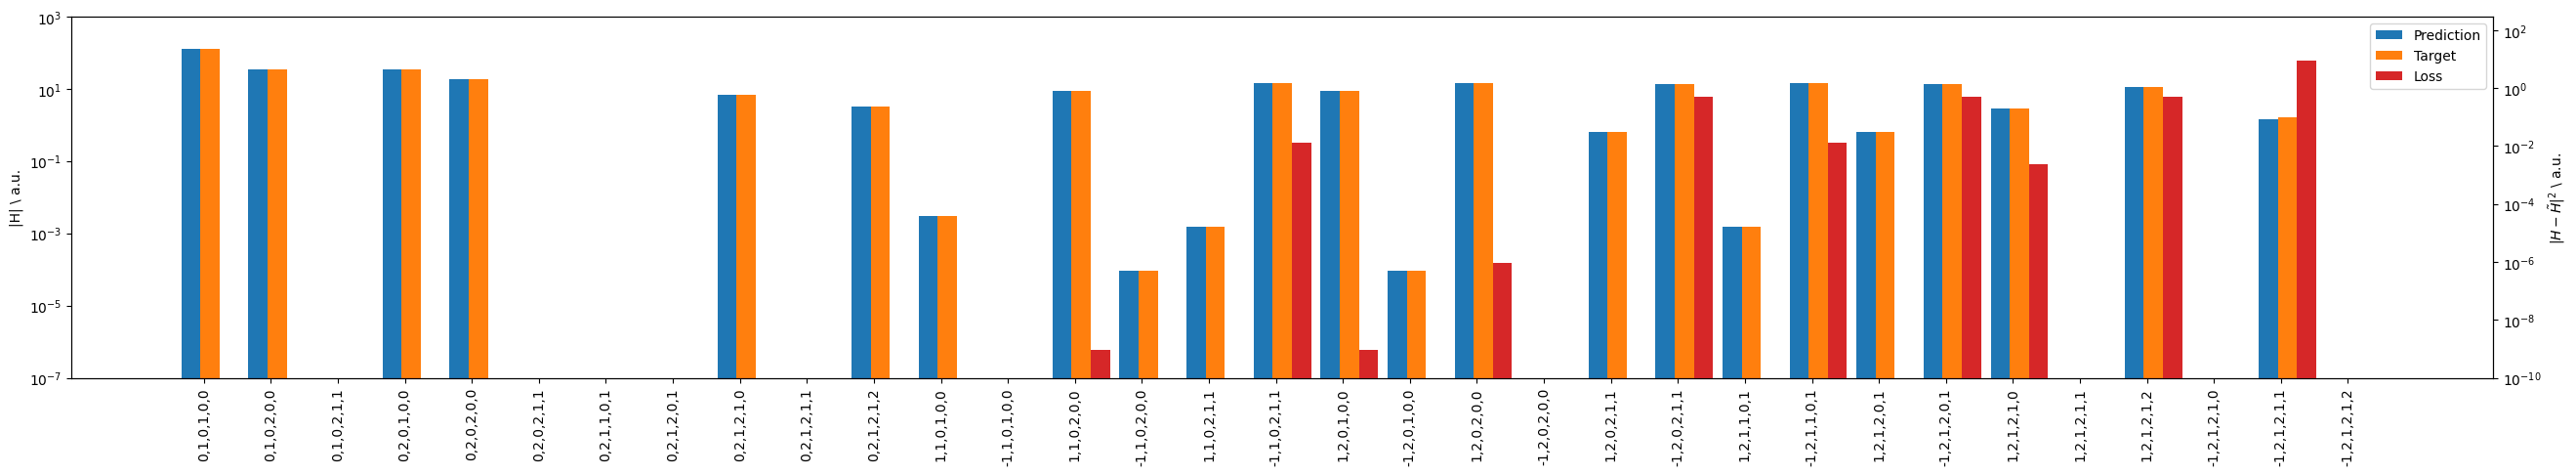

In [185]:
plot_block_errors(pred_ridge_bias, target_coupled_blocks['hex'], plot_loss=True)

##### Predict hex

In [146]:

model = LinearModelPeriodic(twocfeat=hfeat_hex, target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)


cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [1 7 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]
 [3 4 0]
 [3 5 0]
 [3 6 0]
 [3 7 0]
 [4 0 0]
 [4 1 0]
 [4 2 0]
 [4 3 0]
 [4 4 0]
 [4 5 0]
 [4 6 0]
 [4 7 0]
 [5 0 0]
 [5 1 0]
 [5 2 0]
 [5 3 0]
 [5 4 0]
 [5 5 0]
 [5 6 0]
 [5 7 0]
 [6 0 0]
 [6 1 0]
 [6 2 0]
 [6 3 0]
 [6 4 0]
 [6 5 0]
 [6 6 0]
 [6 7 0]
 [7 0 0]
 [7 1 0]
 [7 2 0]
 [7 3 0]
 [7 4 0]
 [7 5 0]
 [7 6 0]
 [7 7 0]] 64


In [147]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks['hex'][0].properties
targetkeynames = target_coupled_blocks['hex'].keys.names
for imdl, (key, tkey) in enumerate(zip(model.model,target_coupled_blocks['hex'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['hex'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_hex, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )

pred = TensorMap(target_coupled_blocks['hex'].keys, pred_blocks)
loss = {}
for k, tb in target_coupled_blocks['hex'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2 

In [148]:
print(loss)

print(sum(loss.values()))

{(0, 6, 1, 0, 6, 1, 0, 0): tensor(1.8630e-11), (0, 6, 1, 0, 6, 2, 0, 0): tensor(9.4292e-15), (0, 6, 1, 0, 6, 2, 1, 1): tensor(1.0626e-16), (0, 6, 2, 0, 6, 1, 0, 0): tensor(9.4292e-15), (0, 6, 2, 0, 6, 2, 0, 0): tensor(6.3841e-15), (0, 6, 2, 0, 6, 2, 1, 1): tensor(8.6463e-21), (0, 6, 2, 1, 6, 1, 0, 1): tensor(1.0626e-16), (0, 6, 2, 1, 6, 2, 0, 1): tensor(8.6463e-21), (0, 6, 2, 1, 6, 2, 1, 0): tensor(1.6211e-14), (0, 6, 2, 1, 6, 2, 1, 1): tensor(0.), (0, 6, 2, 1, 6, 2, 1, 2): tensor(4.0504e-16), (1, 6, 1, 0, 6, 1, 0, 0): tensor(6.0412e-09), (-1, 6, 1, 0, 6, 1, 0, 0): tensor(1.0766e-25), (1, 6, 1, 0, 6, 2, 0, 0): tensor(0.0276), (-1, 6, 1, 0, 6, 2, 0, 0): tensor(1.1165e-18), (1, 6, 1, 0, 6, 2, 1, 1): tensor(1.9141e-14), (-1, 6, 1, 0, 6, 2, 1, 1): tensor(0.0177), (1, 6, 2, 0, 6, 1, 0, 0): tensor(0.0276), (-1, 6, 2, 0, 6, 1, 0, 0): tensor(1.1166e-18), (1, 6, 2, 0, 6, 2, 0, 0): tensor(0.0449), (-1, 6, 2, 0, 6, 2, 0, 0): tensor(2.8882e-27), (1, 6, 2, 0, 6, 2, 1, 1): tensor(2.9110e-15), (-1, 6

##### Train c1

In [17]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_c1, target_blocks=target_coupled_blocks['24'], frames = dataset['24'].structures, orbitals= dataset['24'].basis, cell_shifts=dataset['24'].desired_shifts[:], device = device)

cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [1 7 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]
 [3 4 0]
 [3 5 0]
 [3 6 0]
 [3 7 0]
 [4 0 0]
 [4 1 0]
 [4 2 0]
 [4 3 0]
 [4 4 0]
 [4 5 0]
 [4 6 0]
 [4 7 0]
 [5 0 0]
 [5 1 0]
 [5 2 0]
 [5 3 0]
 [5 4 0]
 [5 5 0]
 [5 6 0]
 [5 7 0]
 [6 0 0]
 [6 1 0]
 [6 2 0]
 [6 3 0]
 [6 4 0]
 [6 5 0]
 [6 6 0]
 [6 7 0]
 [7 0 0]
 [7 1 0]
 [7 2 0]
 [7 3 0]
 [7 4 0]
 [7 5 0]
 [7 6 0]
 [7 7 0]] 64


In [18]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['24'], set_bias=True)


In [19]:
print(loss_ridge_bias)

tensor(0.0005)


##### Predict c1

In [20]:

model = LinearModelPeriodic(twocfeat=hfeat_c1, target_blocks=target_coupled_blocks['24'], frames = dataset['24'].structures, orbitals= dataset['24'].basis, cell_shifts=dataset['24'].desired_shifts[:], device = device)


cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [1 7 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]
 [3 4 0]
 [3 5 0]
 [3 6 0]
 [3 7 0]
 [4 0 0]
 [4 1 0]
 [4 2 0]
 [4 3 0]
 [4 4 0]
 [4 5 0]
 [4 6 0]
 [4 7 0]
 [5 0 0]
 [5 1 0]
 [5 2 0]
 [5 3 0]
 [5 4 0]
 [5 5 0]
 [5 6 0]
 [5 7 0]
 [6 0 0]
 [6 1 0]
 [6 2 0]
 [6 3 0]
 [6 4 0]
 [6 5 0]
 [6 6 0]
 [6 7 0]
 [7 0 0]
 [7 1 0]
 [7 2 0]
 [7 3 0]
 [7 4 0]
 [7 5 0]
 [7 6 0]
 [7 7 0]] 64


In [21]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks['24'][0].properties
targetkeynames = target_coupled_blocks['24'].keys.names
for imdl, (key, tkey) in enumerate(zip(model.model,target_coupled_blocks['24'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['24'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_c1, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )

pred = TensorMap(target_coupled_blocks['24'].keys, pred_blocks)
loss = {}
for k, tb in target_coupled_blocks['24'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2 

In [22]:
print(loss)

print(sum(loss.values()))

{(0, 6, 1, 0, 6, 1, 0, 0): tensor(2.8634e-11), (0, 6, 1, 0, 6, 2, 0, 0): tensor(8.7324e-14), (0, 6, 1, 0, 6, 2, 1, 1): tensor(6.3078e-20), (0, 6, 2, 0, 6, 1, 0, 0): tensor(8.7324e-14), (0, 6, 2, 0, 6, 2, 0, 0): tensor(1.3673e-13), (0, 6, 2, 0, 6, 2, 1, 1): tensor(2.5192e-17), (0, 6, 2, 1, 6, 1, 0, 1): tensor(6.3078e-20), (0, 6, 2, 1, 6, 2, 0, 1): tensor(2.5192e-17), (0, 6, 2, 1, 6, 2, 1, 0): tensor(1.6252e-15), (0, 6, 2, 1, 6, 2, 1, 1): tensor(1.7307e-33), (0, 6, 2, 1, 6, 2, 1, 2): tensor(4.1775e-15), (1, 6, 1, 0, 6, 1, 0, 0): tensor(2.1515e-08), (-1, 6, 1, 0, 6, 1, 0, 0): tensor(8.8242e-26), (1, 6, 1, 0, 6, 2, 0, 0): tensor(4.3760e-14), (-1, 6, 1, 0, 6, 2, 0, 0): tensor(1.0615e-19), (1, 6, 1, 0, 6, 2, 1, 1): tensor(2.3952e-21), (-1, 6, 1, 0, 6, 2, 1, 1): tensor(6.3648e-08), (1, 6, 2, 0, 6, 1, 0, 0): tensor(4.3760e-14), (-1, 6, 2, 0, 6, 1, 0, 0): tensor(1.0586e-19), (1, 6, 2, 0, 6, 2, 0, 0): tensor(1.3963e-10), (-1, 6, 2, 0, 6, 2, 0, 0): tensor(4.9463e-27), (1, 6, 2, 0, 6, 2, 1, 1): te

## C2 24 

In [7]:
target_blocks = {name: get_targets(dataset[name])[0] for name in ['24']}
target_coupled_blocks = {name: get_targets(dataset[name])[1] for name in ['24']}

In [8]:
target_coupled_blocks

{'24': TensorMap with 33 blocks
 keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
           0           6       1    0       6       1    0   0
           0           6       1    0       6       2    0   0
                                ...
           -1          6       2    1       6       2    1   1
           -1          6       2    1       6       2    1   2}

In [9]:
pred_ = load('examples/data/periodic/c2/train_cosmosrv/pred_ridges_24-nostupid.npz', use_numpy=True)
loss_blocks = {}
for k, b in target_coupled_blocks['24'].items():
    loss_blocks[tuple(k)] = torch.linalg.norm(b.values - pred_.block(k).values)**2

loss_= sum(loss_blocks.values())
print(loss_)

tensor(1.6201)


In [35]:
import metatensor.operations as ops 
loss_frame = {}
block_norms = {}
for ifr in range(len(frames)): 
    if ifr==3: 
        continue
    loss_frame[ifr] = {}
    block_norms[ifr] = {}
    frame_target = ops.slice(target_coupled_blocks['24'], axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    frame_pred = ops.slice(pred_, axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    
    for (k, b),(k1,b1) in zip(frame_target.items(), frame_pred.items()):
        loss_frame[ifr][tuple(k)] = torch.linalg.norm(b.values - b1.values)**2
        block_norms[ifr][tuple(k)] = torch.linalg.norm(b.values) 

In [36]:
np.sum( [list(loss_frame[ifr].values()) for ifr in loss_frame])

0.10795432446778783

In [123]:
hfeat_norms = np.load('examples/data/periodic/c2/train_cosmosrv/hfeat_norms.npy', allow_pickle=True).item()


In [ ]:
feat_frame = {}
for ifr in fock_range: 
    feat_frame[ifr] = {}

    frame_target = ops.slice(hfeat, axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    
    for (k, b) in frame_target.items():
        feat_frame[ifr][tuple(k)] = np.linalg.norm(b.values) 

In [187]:
val,idx,counts=np.unique([block_norms[ifr][tuple(k)] for ifr in range(24)], return_counts=True, return_index=True)
np.sort(counts)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [21]:
view(frames)

<Popen: returncode: None args: ['/home/nigam/miniconda3/bin/python', '-m', '...>

IndexError: index 23 is out of bounds for axis 0 with size 23

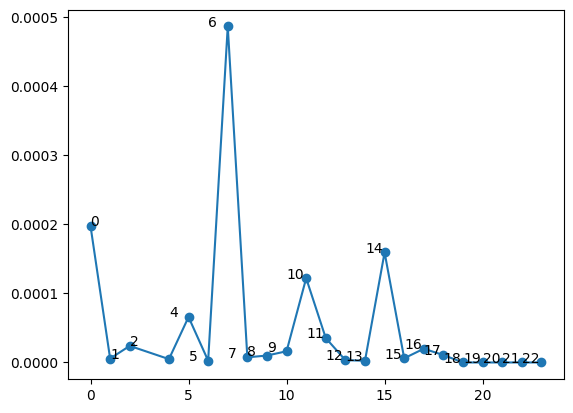

In [37]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
ks = [
    # [1,  6,  1,  0,  6,  2,  1,  1],
      [-1,  6,  1,  0,  6,  2,  1,  1],
      # [ 1,  6,  2,  1,  6,  2,  1,  0],
      # [ -1,  6,  2,  1,  6,  2,  1,  0],
      # [ 1,  6,  2,  1,  6,  2,  1,  1],
      # [ -1,  6,  2,  1,  6,  2,  1,  0],
      [ 1,  6,  2,  1,  6,  2,  1,  2],
      # [ -1,  6,  2,  1,  6,  2,  1,  2]
     ]
featkey = [ 
            [3, 1, 1, 6, 6, -1],
    [3, 1, 2, 6, 6, 1]
]
# color_cycle = plt.cm._get_lines.color_cycle
axes = []
handles=[]
labels=[]
for k,fk in zip(ks,featkey):
    fig, ax = plt.subplots()
    # axes.append(ax.twinx())
    losses = np.array([loss_frame[ifr][tuple(k)].numpy() for ifr in loss_frame])
    x = [ifr for ifr in loss_frame]
    
# ax.hist(losses)
    pl,=ax.plot([0],[0],lw=0)
    # pl,=axes[-1].plot(range(24), losses, '-o', label = k, color=pl.get_color())
    pl,=ax.plot(x, losses, '-o', label = k, color=pl.get_color())

    ym,yM=ax.get_ylim()
    delta=yM-ym
    for ifr in block_norms:
        # ax.annotate(f'{ifr}--{block_norms[ifr][tuple(k)].item():.2e}', xy=(ifr, losses[ifr]))
        ax.annotate(f'{ifr}', xy=(ifr, losses[ifr]))
        # ax.annotate(f'{ifr}-{block_norms[ifr][tuple(k)].item():.2e}', xy=(ifr, losses[ifr]))
        # ax.annotate(f'{hfeat_norms[ifr][tuple(fk)]:.2e}', xy=(ifr, losses[ifr]-delta*0.05))
    ax.legend()
    ax.set_xlim(0,24)
#     handles.append(pl)
#     labels.append(k)
# ax.legend(handles,labels,loc='center left', bbox_to_anchor=(1.2,0.5))

In [125]:
hfeat_norms

{0: {(3, 1, 0, 6, 6, 0): 9.097396,
  (3, 1, 1, 6, 6, 0): 0.6262477,
  (3, 1, 2, 6, 6, 0): 13.937294,
  (3, 1, 3, 6, 6, 0): 12.641046,
  (3, -1, 1, 6, 6, 0): 0.018247489,
  (3, -1, 2, 6, 6, 0): 0.4864036,
  (3, -1, 3, 6, 6, 0): 0.67403245,
  (3, -1, 0, 6, 6, 0): 0.00017152075,
  (3, 1, 0, 6, 6, 1): 13.171967,
  (3, 1, 0, 6, 6, -1): 3.9273574,
  (3, 1, 1, 6, 6, 1): 9.180235,
  (3, 1, 1, 6, 6, -1): 21.611542,
  (3, 1, 2, 6, 6, 1): 30.744743,
  (3, 1, 2, 6, 6, -1): 11.924061,
  (3, 1, 3, 6, 6, 1): 14.20525,
  (3, 1, 3, 6, 6, -1): 32.158245,
  (3, -1, 1, 6, 6, 1): 4.297552,
  (3, -1, 1, 6, 6, -1): 7.32977,
  (3, -1, 2, 6, 6, 1): 9.432269,
  (3, -1, 2, 6, 6, -1): 18.025658,
  (3, -1, 3, 6, 6, 1): 18.280693,
  (3, -1, 3, 6, 6, -1): 10.509862,
  (3, -1, 0, 6, 6, 1): 0.0054351743,
  (3, -1, 0, 6, 6, -1): 0.0604024},
 1: {(3, 1, 0, 6, 6, 0): 8.571795,
  (3, 1, 1, 6, 6, 0): 0.99372596,
  (3, 1, 2, 6, 6, 0): 13.097979,
  (3, 1, 3, 6, 6, 0): 12.020926,
  (3, -1, 1, 6, 6, 0): 0.0104065165,
  (3, -1,

In [42]:
for k, b in target_coupled_blocks['hex'].items():
    print(f'[{" ".join([f"{s:>2d}," for s in k.values])}]  {torch.linalg.norm(b.values).item():.2e}, {loss_blocks[tuple(k)].item():.2e}')

[ 0,  6,  1,  0,  6,  1,  0,  0,]  6.11e+02, 4.75e-07
[ 0,  6,  1,  0,  6,  2,  0,  0,]  1.65e+02, 2.24e-08
[ 0,  6,  1,  0,  6,  2,  1,  1,]  5.57e-02, 1.09e-13
[ 0,  6,  2,  0,  6,  1,  0,  0,]  1.65e+02, 2.24e-08
[ 0,  6,  2,  0,  6,  2,  0,  0,]  9.63e+01, 6.04e-07
[ 0,  6,  2,  0,  6,  2,  1,  1,]  1.57e+00, 1.65e-13
[ 0,  6,  2,  1,  6,  1,  0,  1,]  5.57e-02, 1.09e-13
[ 0,  6,  2,  1,  6,  2,  0,  1,]  1.57e+00, 1.65e-13
[ 0,  6,  2,  1,  6,  2,  1,  0,]  4.45e+01, 1.40e-06
[ 0,  6,  2,  1,  6,  2,  1,  1,]  4.40e-16, 1.65e-16
[ 0,  6,  2,  1,  6,  2,  1,  2,]  2.02e+01, 5.65e-09
[ 1,  6,  1,  0,  6,  1,  0,  0,]  3.00e-02, 1.78e-07
[-1,  6,  1,  0,  6,  1,  0,  0,]  1.04e-12, 1.09e-24
[ 1,  6,  1,  0,  6,  2,  0,  0,]  5.26e+01, 9.73e-09
[-1,  6,  1,  0,  6,  2,  0,  0,]  2.07e-03, 3.68e-10
[ 1,  6,  1,  0,  6,  2,  1,  1,]  7.78e-03, 5.62e-10
[-1,  6,  1,  0,  6,  2,  1,  1,]  8.74e+01, 1.11e-01
[ 1,  6,  2,  0,  6,  1,  0,  0,]  5.26e+01, 9.72e-09
[-1,  6,  2,  0,  6,  1,  0,

In [56]:
keys = [[-1,  6,  1,  0,  6,  2,  1,  1], [ 1,  6,  2,  1,  6,  2,  1,  2]]
sample_idx = 100
for k in keys:
    b = target_coupled_blocks['hex'].block(bkey)
    bkey = Labels(target_coupled_blocks['hex'].keys.names, np.asarray(k).reshape(1,-1))
    print(target_coupled_blocks['hex'].block(bkey).values[sample_idx])
    print()
    print(pred_.block(bkey).values[sample_idx])
    print()

tensor([[ 1.9081e-07],
        [-1.2094e-06],
        [ 1.1727e-06]])

[[-1.2288465e-06]
 [ 1.2046726e-05]
 [-2.5015042e-05]]

tensor([[ 1.1322e-04],
        [ 1.9674e-05],
        [ 1.7823e-03],
        [-5.9196e-06],
        [ 9.8322e-05]])

[[4.0667036e-04]
 [5.7109901e-05]
 [1.4171307e-03]
 [4.1607036e-05]
 [7.8619385e-05]]



In [60]:
b.samples.values.shape

(4560, 6)

In [73]:
# 4560/24 - 63*3 -1 

0.0

In [72]:
b.samples

LabelsValues([[ 0,  0,  0,  0,  1,  0],
              [ 0,  0,  0,  0,  2,  0],
              [ 0,  0,  0,  0,  3,  0],
              ...,
              [23,  1,  1,  7,  5,  0],
              [23,  1,  1,  7,  6,  0],
              [23,  1,  1,  7,  7,  0]], dtype=int32)

In [6]:
# kfock['hex'].shape, kfock['double_hex'].shape

## FEATURES 

In [46]:
hypers_pair = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.6,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}

hypers_atom = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}
device = "cpu"

In [ ]:
new_names=['ortho', 'hex', 'hex22', 'hex33', 'hex23']
NAMES_START=1
NAMES_STOP=2
LCUT = 3 #2*np.max([np.max( np.asarray(orbitals[ORBS][k])[:,1]) for k in orbitals[ORBS]])
print("LCUT", LCUT)
both_centers = True
rhoij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, 
                               both_centers=both_centers, max_shift = dataset[name].kmesh[0] ,  
                               desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], 
                               device="cpu", lcut = LCUT) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}
# gij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=both_centers, max_shift = dataset[name].kmesh[0] ,  desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], device="cpu", return_rho0ij=True) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}
# #THIS IS SLOW 

In [ ]:
# both_centers=False
mic=True
# # desired_shifts = None
# # desired_shifts = dataset[name].desired_shifts_sup
gij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=both_centers, max_shift = [8,8,1] ,  desired_shifts =  dataset[name].desired_shifts_sup, mic=mic, kmesh = dataset[name].kmesh[0], device="cpu", return_rho0ij=True) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}


In [48]:
if both_centers: 
    NU = 3
else: 
    NU = 2
rhonui = {newname: single_center_features(dataset[name].structures, hypers_atom, order_nu=NU, lcut=LCUT, 
                                          device = device, feature_names = rhoij[newname].property_names,) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}


In [ ]:
hfeat_tc= {name: twocenter_features_periodic_NH(single_center=rhonui[name], pair= rhoij[name]) for name in new_names[NAMES_START:NAMES_STOP]}

In [56]:
# hfeat_tc['hex'].save('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex', use_numpy=True)
# hfeat_tc['hex22'].save('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22', use_numpy=True)

# hfeat_tc['hex'].save('examples/data/periodic/c2/hfeat_tc_hex/results_C2_rotated_881/hfeat_tc.npz', use_numpy=True) # ROTATED structure
# aa = load("rhoij_hex.npz", use_numpy=True) 
# aa.to(arrays='torch')

/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/io.py:408: UserWarning: adding '.npz' extension, the file will be saved at 'examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex.npz'
  warnings.warn(
/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/io.py:408: UserWarning: adding '.npz' extension, the file will be saved at 'examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22.npz'
  warnings.warn(


# ROTATION TEST 

In [9]:
hfeat_tc={}
# hfeat_tc['hex'] = load("examples/data/periodic/c2/results_C2_rotated_881/hfeat_tc.npz", use_numpy=True) 
# hfeat_tc['hex'] = hfeat_tc['hex'].to(arrays='torch')

In [10]:
from mlelec.utils.symmetry import _wigner_d_real, rotate_frame, _rotation_matrix_from_angles
import hickle

In [11]:
rotation = hickle.load('/home/nigam/scratch/MAC/mlelec/examples/data/water_rotated/rotations.hickle')

In [12]:
hex_rot = rotate_frame(dataset['hex'].structures[0], _rotation_matrix_from_angles(*rotation[1]))

In [15]:
dataset['hex_rot'] = PySCFPeriodicDataset(frames = [hex_rot], kgrid=kmesh, matrices_kpoint = kfock, overlap_kpoint=kover, target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS])

In [16]:
hfeat = {}
for name in ['hex', 'hex_rot']:
    hfeat[name]= compute_features(dataset[name])

LCUT 3
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 12.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


bef [0 1 0] [ 0 -1  0] aft [0 1 0] [0 1 0]
0 0 0 mic 0 1 0 m_mic 0 1 0
bef [0 2 0] [ 0 -2  0] aft [0 2 0] [0 2 0]
0 0 0 mic 0 2 0 m_mic 0 2 0
bef [0 3 0] [ 0 -3  0] aft [0 3 0] [0 3 0]
0 0 0 mic 0 3 0 m_mic 0 3 0
bef [0 4 0] [ 0 -4  0] aft [0 4 0] [0 4 0]
0 0 0 mic 0 4 0 m_mic 0 4 0
bef [ 0 -3  0] [0 3 0] aft [0 3 0] [0 3 0]
0 0 0 mic 0 3 0 m_mic 0 3 0
bef [ 0 -2  0] [0 2 0] aft [0 2 0] [0 2 0]
0 0 0 mic 0 2 0 m_mic 0 2 0
bef [ 0 -1  0] [0 1 0] aft [0 1 0] [0 1 0]
0 0 0 mic 0 1 0 m_mic 0 1 0
bef [1 0 0] [-1  0  0] aft [1 0 0] [1 0 0]
0 0 0 mic 1 0 0 m_mic 1 0 0
bef [1 1 0] [-1 -1  0] aft [1 1 0] [1 1 0]
0 0 0 mic 1 1 0 m_mic 1 1 0
bef [1 2 0] [-1 -2  0] aft [1 2 0] [1 2 0]
0 0 0 mic 1 2 0 m_mic 1 2 0
bef [1 3 0] [-1 -3  0] aft [1 3 0] [1 3 0]
0 0 0 mic 1 3 0 m_mic 1 3 0
bef [ 1 -4  0] [-1  4  0] aft [ 1 -4  0] [ 1 -4  0]
0 0 0 mic 1 -4 0 m_mic 1 -4 0
bef [ 1 -3  0] [-1  3  0] aft [ 1 -3  0] [ 1 -3  0]
0 0 0 mic 1 -3 0 m_mic 1 -3 0
bef [ 1 -2  0] [-1  2  0] aft [ 1 -2  0] [ 1 -2  0]
0 0

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:382: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


190
190
190
190
190
190
190
190
LCUT 3
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
bef [0 1 0] [ 0 -1  0] aft [0 1 0] [0 1 0]
0 0 0 mic 0 1 0 m_mic 0 1 0
bef [0 2 0] [ 0 -2  0] aft [0 2 0] [0 2 0]
0 0 0 mic 0 2 0 m_mic 0 2 0
bef [0 3 0] [ 0 -3  0] aft [0 3 0] [0 3 0]
0 0 0 mic 0 3 0 m_mic 0 3 0
bef [0 4 0] [ 0 -4  0] aft [0 4 0] [0 4 0]
0 0 0 mic 0 4 0 m_mic 0 4 0
bef [ 0 -3  0] [0 3 0] aft [0 3 0] [0 3 0]
0 0 0 mic 0 3 0 m_mic 0 3 0
bef [ 0 -2  0] [0 2 0] aft [0 2 0] [0 2 0]
0 0 0 mic 0 2 0 m_mic 0 2 0
bef [ 0 -1  0] [0 1 0] aft [0 1 0] [0 1 0]
0 0 0 mic 0 1 0 m_mic 0 1 0
bef [1 0 0] [-1  0  0] aft [1 0 0] [1 0 0]
0 0 0 mic 1 0 0 m_mic 1 0 0
bef [1 1 0] [-1 -1  0] aft [1 1 0] [1 1 0]
0 0 0 mic 1 1 0 m_mic 1 1 0
bef [1 2 0] [-1 -2  0] aft [1 2 0] [1 2 0]
0 0 0 mic 1 2 0 m_mic 1 2 0
bef [1 3 0] [-1 -3  0] aft [1 3 0] [1 3 0]
0 0 0

In [38]:
for k, b in hfeat['hex'].items():
   
        # lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
        # sample1,sidx1 = labels_where(b.samples, lbl1, return_idx=True )
    
        # lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
        # sample2,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
        sample1 = b.samples
        v1 = b.values
        rotblock = hfeat['hex_rot'].block(k)
        v2 = rotblock.values
        sample2 = rotblock.samples
    
        L = k["spherical_harmonics_l"]
        wd = _wigner_d_real(L, *rotation[1]).to(b.values)
        v1_rot = torch.einsum('mn, snp->smp', wd, v1)
        # print(sample1.values.tol)
        # assert np.all(sample1.values[:,:] ==sample2.values[:,:]), (np.where(sample1.values!= sample2.values))
        if torch.linalg.norm(v1_rot - v2) > 1e-6:
            
            print(k.values, torch.linalg.norm(v1_rot - v2), np.linalg.norm(v1_rot), np.linalg.norm(v2))
        # if k['spherical_harmonics_l']==1:

[ 3  1  0  6  6 -1] tensor(0.2273) 3.5552525903408507 3.555252590340852
[3 1 1 6 6 1] tensor(1.4266) 8.164581934359202 8.164581934359198
[ 3  1  1  6  6 -1] tensor(4.3335) 17.564549795779374 17.564549795779357
[3 1 2 6 6 1] tensor(3.3043) 24.916729710354367 24.916729710354407
[ 3  1  2  6  6 -1] tensor(2.1223) 10.771609876220701 10.77160987622069
[3 1 3 6 6 1] tensor(1.5898) 12.750873148168358 12.750873148168361
[ 3  1  3  6  6 -1] tensor(6.1443) 26.12626081617775 26.126260816177844
[ 3 -1  1  6  6  1] tensor(1.5136) 3.578237103024591 3.578237103024593
[ 3 -1  1  6  6 -1] tensor(1.5700) 6.331455982905192 6.331455982905192
[ 3 -1  2  6  6  1] tensor(1.2914) 8.304224556164646 8.304224556164646
[ 3 -1  2  6  6 -1] tensor(3.5425) 14.485751567805243 14.485751567805229
[ 3 -1  3  6  6  1] tensor(2.8844) 14.732225364158577 14.732225364158554
[ 3 -1  3  6  6 -1] tensor(2.2064) 9.26057029936021 9.26057029936018


In [25]:
view(dataset['hex_rot'].structures[0])

<Popen: returncode: None args: ['/home/nigam/miniconda3/bin/python', '-m', '...>

In [37]:
print(sample1.values[45] , sample2.values[45])
print(np.linalg.norm(b.values[45] - rotblock.values[45]))


[0 0 0 5 6 0 3 2 0] [ 0  0  0  5  6  0  5 -2  0]
2.7822853060872896e-16


In [17]:
# x=rotate_frame(frames[0], _rotation_matrix_from_angles(*rotation[1]))
# frames[2].positions - x.positions

In [18]:
# feat = hfeat_tc
for k, b in hfeat['hex'].items():
   
        lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
        sample1,sidx1 = labels_where(b.samples, lbl1, return_idx=True )
    
        lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
        sample2,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
        v1 = b.values[sidx1]
        v2 = b.values[sidx2] 
        L = k["spherical_harmonics_l"]
        wd = _wigner_d_real(L, *rotation[0]).to(b.values)
        v1_rot = torch.einsum('mn, snp->smp', wd, v1)
        assert np.all(sample1.values[:,1:] ==sample2.values[:,1:])
        if torch.linalg.norm(v1_rot - v2) > 1e-6:
            
            print(k.values, torch.linalg.norm(v1_rot - v2), np.linalg.norm(v1_rot), np.linalg.norm(v2))
        # if k['spherical_harmonics_l']==1:
        #      break


[3 1 2 6 6 0] tensor(1.2170e-06) 17.09286 17.092861
[3 1 3 6 6 0] tensor(1.1005e-06) 14.451293 14.451231
[ 3  1  0  6  6 -1] tensor(0.0639) 4.198944 4.198944
[ 3  1  1  6  6 -1] tensor(1.7349) 24.39134 24.391092
[3 1 2 6 6 1] tensor(2.7382e-06) 34.757538 34.756935
[ 3  1  2  6  6 -1] tensor(1.0585) 12.806403 12.806394
[3 1 3 6 6 1] tensor(1.3880e-06) 15.279838 15.278668
[ 3  1  3  6  6 -1] tensor(2.8915) 36.18892 36.188015
[ 3 -1  1  6  6 -1] tensor(1.0798) 7.8203564 7.8202767
[ 3 -1  2  6  6  1] tensor(1.0141e-06) 10.113193 10.113056
[ 3 -1  2  6  6 -1] tensor(1.4754) 20.653122 20.652864
[ 3 -1  3  6  6  1] tensor(1.8454e-06) 20.817873 20.817661
[ 3 -1  3  6  6 -1] tensor(1.2645) 11.300896 11.300827


In [298]:
for k, b in target_coupled_blocks['hex'].items():
    lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
    _,sidx1 = labels_where(b.samples, lbl1, return_idx=True )

    lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
    _,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
    v1 = b.values[sidx1]
    v2 = b.values[sidx2]

    L = k["L"]
    wd = _wigner_d_real(L, *rotation[0]).to(b.values)
    if torch.linalg.norm(wd @ v1 - v2) > 1e-6:
        print(torch.linalg.norm(wd @ v1 - v2), np.linalg.norm(wd @ v1), np.linalg.norm(v2))


tensor(1.3487e-06) 19.907621 19.90762
tensor(1.3487e-06) 9.543349 9.543348
tensor(2.1069e-06) 4.3308372 4.3308372
tensor(1.3040e-06) 11.232675 11.232675
tensor(1.1142e-06) 18.673347 18.673346
tensor(1.3040e-06) 11.232675 11.232675
tensor(2.1132e-06) 17.775105 17.7751
tensor(1.4661e-06) 0.98010755 0.9801072
tensor(1.9969e-06) 17.167927 17.167929
tensor(1.1142e-06) 18.673347 18.673346
tensor(1.4661e-06) 0.98010755 0.9801072
tensor(1.9969e-06) 17.167927 17.167929
tensor(1.1793e-06) 4.3840656 4.3840656
tensor(2.0731e-06) 14.030686 14.030686


# Compare FEATURES hex, hex22

In [205]:
#GIJ
from torch.linalg import norm 
KEY = 0
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]
atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0]

print(gij['hex'].keys[KEY])
lbl = Labels(gij['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(gij['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(gij['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(gij['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(gij['hex'][KEY].values[ucidx]- gij['hex22'][KEY].values[scidx]))


LabelsEntry(order_nu=1, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6)


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c'] = [0 0 0 4 5 0] not found in the output keys. Check the `selection` argument.

In [87]:

from metatensor import equal, equal_metadata, allclose, allclose_block, sort, sort_block

In [88]:
#RHOIJ
KEY = 0
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]
atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0]

print(rhoij['hex'].keys[KEY])
lbl = Labels(rhoij['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(rhoij['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(rhoij['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(rhoij['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(rhoij['hex'][KEY].values[ucidx]- rhoij['hex22'][KEY].values[scidx]))
print(norm(rhoij['hex'][KEY].values[ucidx]), norm(rhoij['hex22'][KEY].values[scidx]))

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6)


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c'] = [0 0 0 4 5 0] not found in the output keys. Check the `selection` argument.

In [89]:
#HFEAT
print(hfeat_tc['hex'].keys[8])
KEY = 8
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]

atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0] 
lbl = Labels(hfeat_tc['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(hfeat_tc['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(hfeat_tc['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(hfeat_tc['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(hfeat_tc['hex'][KEY].values[ucidx]- hfeat_tc['hex22'][KEY].values[scidx]))

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=-1)


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c'] = [0 0 0 4 5 0] not found in the output keys. Check the `selection` argument.

In [90]:
hfeat_tc['hex'].keys[8]

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=-1)

# LEARN 

In [50]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_hamiltonian 

In [51]:
device = "cpu"

In [52]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [53]:
def train_linear(model, target_blocks, nepochs, optimizer= None, log_interval =1):

    losses = []
    for epoch in range(nepochs):
        optimizer.zero_grad()
        pred = model(return_matrix = False)


        loss = 0
        for s in pred:
            for (key, block) in pred[s].items():
                loss+=torch.sum(block.values - target_blocks[s][key].values)**2
        losses.append(loss.item())
        if optimizer is None: 
            print(loss)
            return losses, pred, model
        
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, loss.item()))
            

    return losses, pred, model, optimizer 

In [ ]:
hfeat_tc = {}
hfeat_tc['hex'] = hfeat_hex #load("examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex.npz", use_numpy=True)
# hfeat_tc['hex'] = hfeat_tc['hex'].to(arrays='torch')
hfeat_tc['hex22'] = compute_features(dataset['double_hex'] )#load("examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22.npz", use_numpy=True)
# hfeat_tc['hex22'] = hfeat_tc['hex22'].to(arrays='torch')

LCUT 3
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 12.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [4, 4, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


bef [0 1 0] [ 0 -1  0] aft [0 1 0] [0 1 0]
0 0 0 mic 0 1 0 m_mic 0 1 0
bef [0 2 0] [ 0 -2  0] aft [0 2 0] [0 2 0]
0 0 0 mic 0 2 0 m_mic 0 2 0
bef [ 0 -1  0] [0 1 0] aft [0 1 0] [0 1 0]
0 0 0 mic 0 1 0 m_mic 0 1 0
bef [1 0 0] [-1  0  0] aft [1 0 0] [1 0 0]
0 0 0 mic 1 0 0 m_mic 1 0 0
bef [1 1 0] [-1 -1  0] aft [1 1 0] [1 1 0]
0 0 0 mic 1 1 0 m_mic 1 1 0
bef [ 1 -2  0] [-1  2  0] aft [ 1 -2  0] [ 1 -2  0]
0 0 0 mic 1 -2 0 m_mic 1 -2 0
bef [ 1 -1  0] [-1  1  0] aft [ 1 -1  0] [ 1 -1  0]
0 0 0 mic 1 -1 0 m_mic 1 -1 0
bef [2 0 0] [-2  0  0] aft [2 0 0] [2 0 0]
0 0 0 mic 2 0 0 m_mic 2 0 0
bef [-2  1  0] [ 2 -1  0] aft [ 2 -1  0] [ 2 -1  0]
0 0 0 mic 2 -1 0 m_mic 2 -1 0
bef [-2  2  0] [ 2 -2  0] aft [ 2 -2  0] [ 2 -2  0]
0 0 0 mic 2 -2 0 m_mic 2 -2 0
bef [ 2 -1  0] [-2  1  0] aft [ 2 -1  0] [ 2 -1  0]
0 0 0 mic 2 -1 0 m_mic 2 -1 0
bef [-1  0  0] [1 0 0] aft [1 0 0] [1 0 0]
0 0 0 mic 1 0 0 m_mic 1 0 0
bef [-1  1  0] [ 1 -1  0] aft [ 1 -1  0] [ 1 -1  0]
0 0 0 mic 1 -1 0 m_mic 1 -1 0
bef [-1  2 

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:382: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


In [66]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_tc['hex'], target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)
# model_ridge = LinearModelPeriodic(twocfeat=hfeat_hexpca, target_blocks=target['hex'], frames = dataset['hex'].structures, orbitals= orbs, cell_shifts=dataset['hex'].desired_shifts[1:], device = device)

cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [1 7 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]
 [3 4 0]
 [3 5 0]
 [3 6 0]
 [3 7 0]
 [4 0 0]
 [4 1 0]
 [4 2 0]
 [4 3 0]
 [4 4 0]
 [4 5 0]
 [4 6 0]
 [4 7 0]
 [5 0 0]
 [5 1 0]
 [5 2 0]
 [5 3 0]
 [5 4 0]
 [5 5 0]
 [5 6 0]
 [5 7 0]
 [6 0 0]
 [6 1 0]
 [6 2 0]
 [6 3 0]
 [6 4 0]
 [6 5 0]
 [6 6 0]
 [6 7 0]
 [7 0 0]
 [7 1 0]
 [7 2 0]
 [7 3 0]
 [7 4 0]
 [7 5 0]
 [7 6 0]
 [7 7 0]] 64


In [67]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=True)


In [68]:
print(loss_ridge_bias)

tensor(5.1213e-05)


In [75]:
# np.save('examples/data/periodic/graphene_supercell_variety/ridges_bias_trainhex.npy', ridges_bias)

5.121330164226558e-05


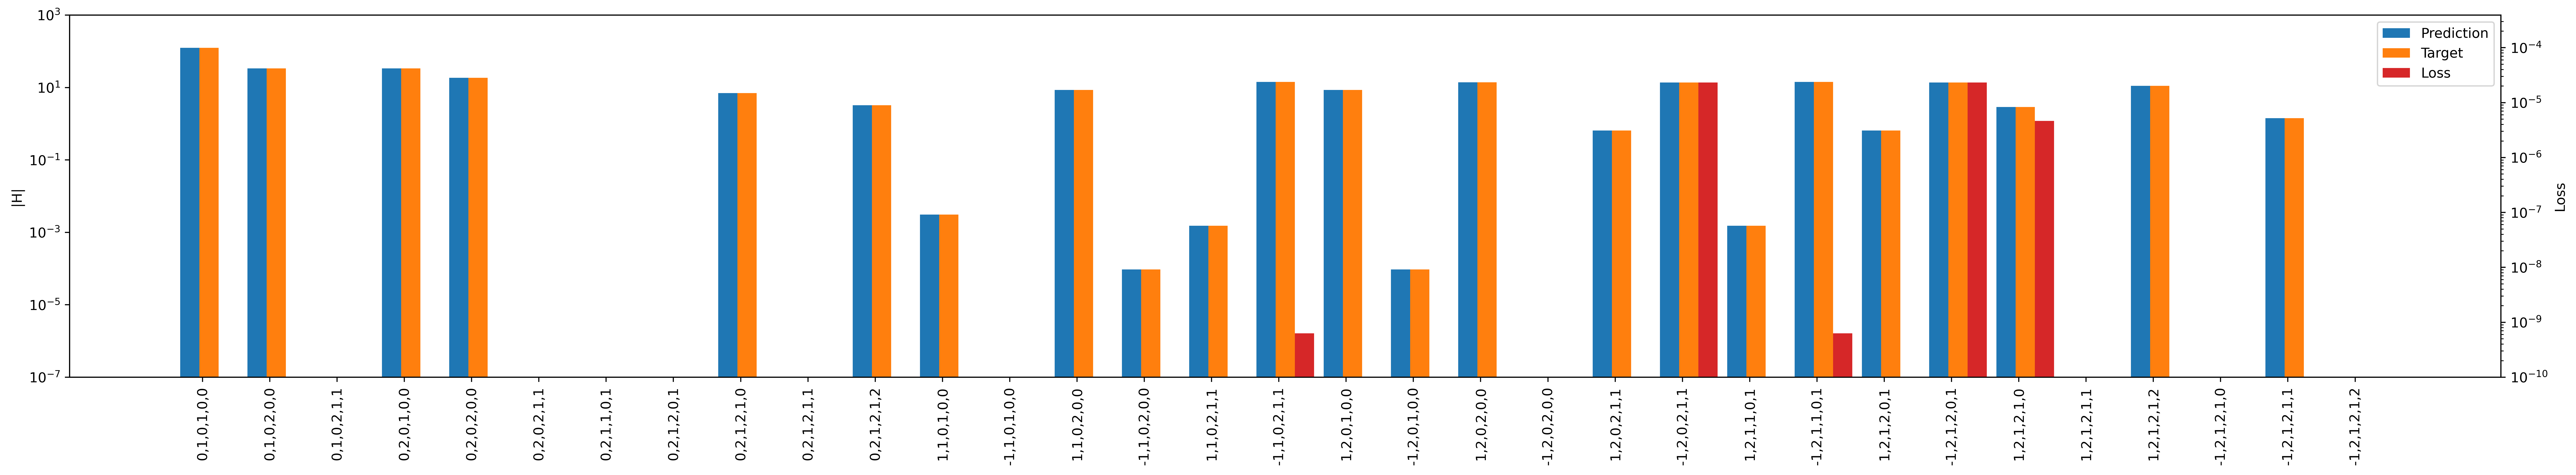

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*5, fs[1]))
ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias])
target_ = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex']])
loss_ = np.array([torch.linalg.norm(b.values-b1.values)**2 for b,b1 in zip(target_coupled_blocks['hex'],pred_ridge_bias)])
print(np.sum(loss_))
# loss_ = np.array(list(loss_blocks.values()))
#MASKING LOSS
# mask = loss_ < 1e-6
# loss_[mask] = 0
# ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
handles.append(pl)
labels.append('Loss')

ax.set_ylim(1e-7, 1000)
ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax_loss.set_ylim(1e-10)
ax.set_yscale('log')

In [70]:
# fig.savefig(results_C2_rotated_881)

# USE the model trained on HEX to predict HEX22

In [71]:
model_ridge_hex22 = LinearModelPeriodic(twocfeat=hfeat_tc['hex22'], target_blocks=target_coupled_blocks['double_hex'], frames = dataset['double_hex'].structures, orbitals= dataset['double_hex'].basis, cell_shifts=dataset['double_hex'].desired_shifts[:], device = device)


cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]] 16


In [72]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
device= "cpu"
pred_hex22_blocks = []
dummy_property = target_coupled_blocks['double_hex'][0].properties
targetkeynames = target_coupled_blocks['double_hex'].keys.names
for imdl, (key, tkey) in enumerate(zip(model_ridge_hex22.model,target_coupled_blocks['double_hex'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['double_hex'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_tc['hex22'], tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_hex22_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )


In [73]:
pred_hex22 = TensorMap(target_coupled_blocks['double_hex'].keys, pred_hex22_blocks)

In [76]:
loss = {}
for k, tb in target_coupled_blocks['double_hex'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred_hex22.block(k).values/2)**2 

In [77]:
print(loss)

{(0, 6, 1, 0, 6, 1, 0, 0): tensor(2.8983e-07), (0, 6, 1, 0, 6, 2, 0, 0): tensor(6.4775e-09), (0, 6, 1, 0, 6, 2, 1, 1): tensor(6.6068e-15), (0, 6, 2, 0, 6, 1, 0, 0): tensor(6.4775e-09), (0, 6, 2, 0, 6, 2, 0, 0): tensor(2.6711e-07), (0, 6, 2, 0, 6, 2, 1, 1): tensor(6.9327e-16), (0, 6, 2, 1, 6, 1, 0, 1): tensor(6.6068e-15), (0, 6, 2, 1, 6, 2, 0, 1): tensor(6.9327e-16), (0, 6, 2, 1, 6, 2, 1, 0): tensor(3.8384e-07), (0, 6, 2, 1, 6, 2, 1, 1): tensor(8.5204e-37), (0, 6, 2, 1, 6, 2, 1, 2): tensor(1.6757e-07), (1, 6, 1, 0, 6, 1, 0, 0): tensor(2.2669e-08), (-1, 6, 1, 0, 6, 1, 0, 0): tensor(1.3474e-26), (1, 6, 1, 0, 6, 2, 0, 0): tensor(1.1690e-08), (-1, 6, 1, 0, 6, 2, 0, 0): tensor(2.0452e-11), (1, 6, 1, 0, 6, 2, 1, 1): tensor(3.3336e-10), (-1, 6, 1, 0, 6, 2, 1, 1): tensor(9.9896e-08), (1, 6, 2, 0, 6, 1, 0, 0): tensor(1.1690e-08), (-1, 6, 2, 0, 6, 1, 0, 0): tensor(2.0452e-11), (1, 6, 2, 0, 6, 2, 0, 0): tensor(2.1792e-08), (-1, 6, 2, 0, 6, 2, 0, 0): tensor(3.9474e-28), (1, 6, 2, 0, 6, 2, 1, 1): te

In [78]:
print(sum(loss.values()))

tensor(4.4050e-05)


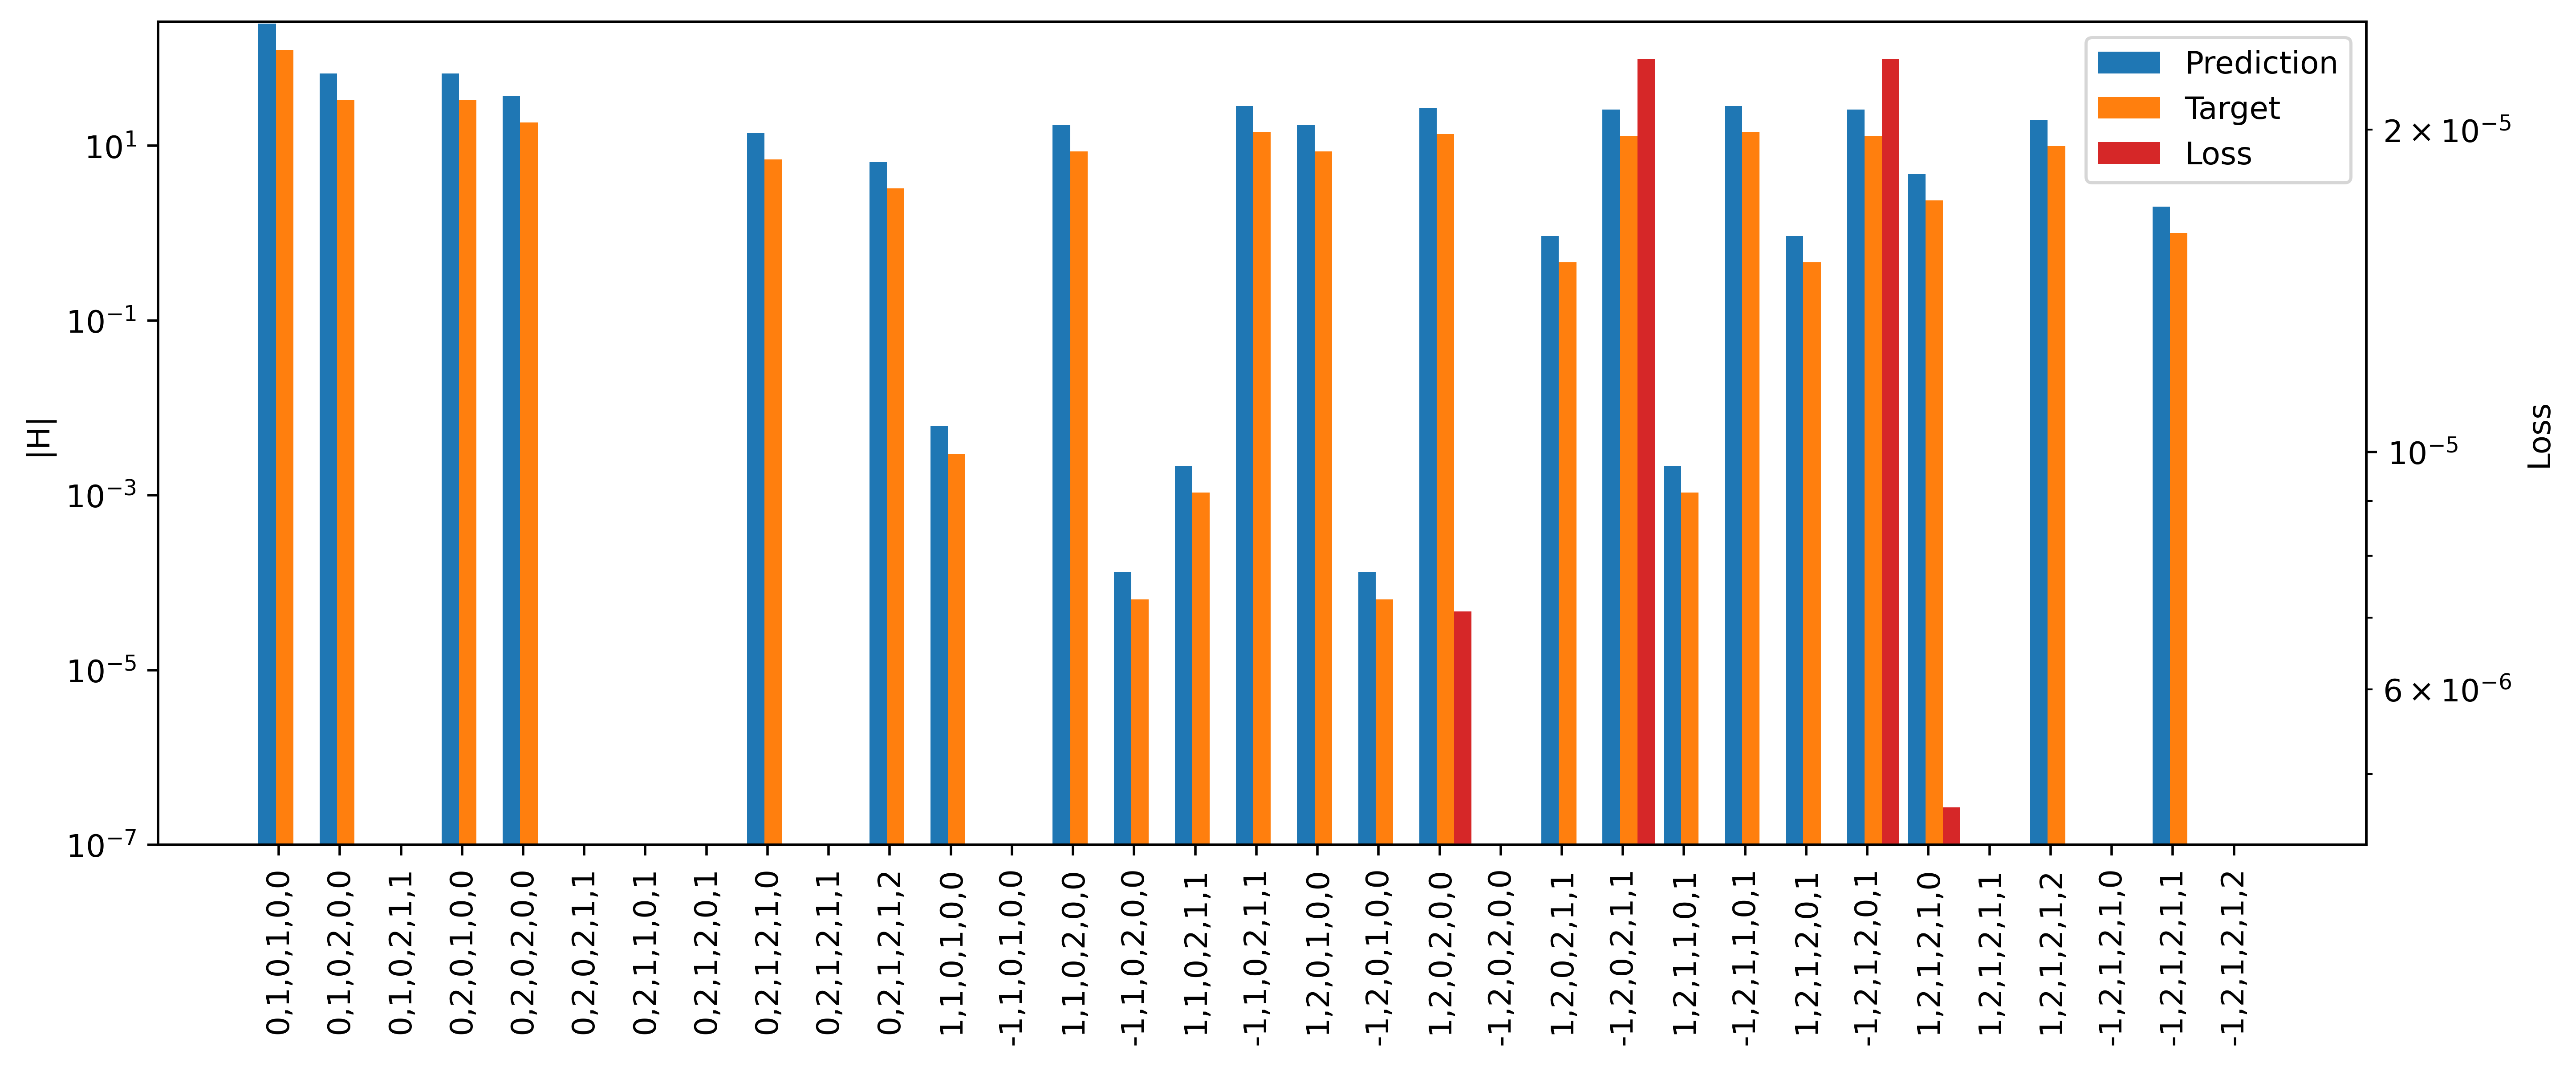

In [77]:
#HEX22
import matplotlib.pyplot as plt
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_hex22])
target_ = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['double_hex']])
loss_ = np.array(list(loss_blocks.values()))
#MASKING LOSS
mask = loss_ < 1e-6
loss_[mask] = 0

# ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
handles.append(pl)
labels.append('Loss')

ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax.set_ylim(1e-7)
# ax_loss.set_ylim(2e-6, 9.9e-2)
ax.set_yscale('log')